# Defining the general class with init, loading, training, eval methods

In [1]:
#################################################################################
#   MAGIC TRICK FOR HAVING tab, shift+tab COMMANDS!
#################################################################################

%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [2]:
import os 
# https://discuss.pytorch.org/t/cuda-launch-blocking-in-jupyter-notebook/163029
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import sys
import gc
from typing import Union
import tqdm

import datetime
import time
import json 

import h5py
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torchvision

try:
    from torchsummary import summary
except: 
    %pip install torchsummary
    from torchsummary import summary


print(f"PyTorch v.\t{torch.__version__}")
print(f"TorchVision v.\t{torchvision.__version__}\n")

# in torch/pytorch data and models need to be moved in the specific processing unit
# this code snippet allows to set the variable "device" according to available resoirce (cpu or cuda gpu)
if torch.cuda.is_available():
    print('number of devices: ', torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sys
from utils.memory_utils import free_memory

PyTorch v.	1.10.1+cu102
TorchVision v.	0.11.2+cu102

number of devices:  1
Tesla T4
Computation device: cuda



/usr/local/lib/python3.6/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Dataset utils
from utils.memory_utils import free_memory
from utils.custom_dataset import XRFAE1DDataset
from utils.pretreatment import custom_transform, normalize_hist, rebin_xrf, tanh_norm
# Model utils
from utils.VAE1D_model import DeepClustering_VAE1D
from utils.save_best_model import SaveBestModel
# Loss utils
from utils.losses import vae_loss_function, silhouette_loss, compute_total_loss
# Clustering utils
from utils.clustering_utils import silhouette_score, IterativeKMeans, KMeans, kpp_init
# VAE utils
from utils.beta_scheduler import BetaScheduler
# Logs utils
from utils.logs_utils import write_line_to_file, store_hyp_dict
# Loader uytils
from utils.open_model import load_model_func

number of devices:  1
Tesla T4
Computation device: cuda

number of devices:  1
Tesla T4
Computation device: cuda

number of devices:  1
Tesla T4
Computation device: cuda

number of devices:  1
Tesla T4
Computation device: cuda

number of devices:  1
Tesla T4
Computation device: cuda

number of devices:  1
Tesla T4
Computation device: cuda



## Define the model


In [4]:
class DeepClustering_trainer(nn.Module):
    def __init__(
        self,
        # Verbosity
        verbosity: int = 1, 
        # Dataset
        CUSTOM_TRANSFORM: bool = False ,
        BASE_DATASET_PATH: str = '/jupyter/notebooks/Article/CHData/Synth/1D/'  ,
        MAX_TRAIN_SIZE: int  = int(20*10e+4) ,
        MAX_VAL_SIZE  : int  = int( 4*10e+4) ,
        MAX_TEST_SIZE : int  = int( 1*10e+4) ,
        # Dataloader
        BATCH_SIZE : int = 256, 
        NUM_WORKERS: int = 6,
        # Model kwargs
        input_dim: int = 512,
        n_layers : int = 4, 
        encoding_space_dim: int = 32, 
        latent_space_dim: int = 6, 
        use_latent_space_activation : bool = True, 
        pow_2_decrease: bool = True, 
        pow_2_increase: bool = True, 
        final_activation = nn.Sigmoid(),
        use_SNN: bool = True,         # If true, Self-Normalising Neural networks are used
        # K-Means
        min_n_cluster: int = 4,
        max_n_cluster: int = 12, 
        Niter: int = 10, 
        random_centroid_init: bool = False, 
        # Optimiser
        learning_rate: float = 1e-3, 
        use_lr_scheduler: bool = True, 
        # Name
        BASE_PATH_TO_STORE: str = './model_data/CHModel',
        base_model_name: str = 'DeepClustering',
        # training
        epochs  : int = 100,
        PATIENCE: int = 10,
        # beta-VAE param
        BETA_MIN: float = 0.0, # NB if BETA_MIN >= BETA_MAX, beta(t) = BETA_MIN forall t
        BETA_MAX: float = 0.0,
        beta_t_number_of_epochs: int = 60,
        beta_t_starting_epoch  : int = 10, 
        beta_t_ending_epoch    : int = 30,
        # Deep Clustering gamma
        γ_init : float = 0.05,
        USE_VARYING_GAMMA: bool = False,
        gamma_t_number_of_epochs: int = 60,
        gamma_t_starting_epoch  : int = 10, 
        gamma_t_ending_epoch    : int = 30,
        # Loss
        USE_SUM : bool  = True,
        # Device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
        
    ):
        super(DeepClustering_trainer, self).__init__()
        
        self.verbosity = verbosity
        self.device = device
        
        # Apply custom transform or not
        self.CUSTOM_TRANSFORM = CUSTOM_TRANSFORM
        self.BASE_DATASET_PATH = BASE_DATASET_PATH
        self.MAX_TRAIN_SIZE = MAX_TRAIN_SIZE
        self.MAX_VAL_SIZE   = MAX_VAL_SIZE
        self.MAX_TEST_SIZE  = MAX_TEST_SIZE
        # Dataloader
        self.BATCH_SIZE  = BATCH_SIZE
        self.NUM_WORKERS = NUM_WORKERS
        
        # INIT DATASET
        self.init_dataset()
        # INIT DATALOADE
        self.init_dataloader()
        
        # Model kwargs
        self.input_dim = input_dim
        self.n_layers = n_layers
        self.encoding_space_dim = encoding_space_dim
        self.latent_space_dim   = latent_space_dim
        self.use_latent_space_activation = use_latent_space_activation
        self.pow_2_decrease = pow_2_decrease
        self.pow_2_increase = pow_2_increase
        self.final_activation = final_activation
        self.min_n_cluster = min_n_cluster
        self.max_n_cluster = max_n_cluster
        self.Niter = Niter
        self.random_centroid_init = random_centroid_init
        self.use_SNN = use_SNN
        self.model_kwargs = {
            "input_dim" : self.input_dim, 
            "n_layers": self.n_layers,
            "encoding_space_dim": self.encoding_space_dim, 
            "latent_space_dim": self.latent_space_dim,
            "use_latent_space_activation": self.use_latent_space_activation,
            "pow_2_decrease": self.pow_2_decrease ,
            "pow_2_increase": self.pow_2_increase ,
            "final_activation": self.final_activation ,
            "min_n_cluster": self.min_n_cluster, 
            "max_n_cluster": self.max_n_cluster, 
            "Niter": self.Niter, 
            "verbose": True if self.verbosity > 0 else False, 
            "random_centroid_init": self.random_centroid_init,
            "use_SNN" : self.use_SNN , 
        }

        # init model
        self.init_model()
        
        # Optimiser
        self.learning_rate    = learning_rate 
        self.use_lr_scheduler = use_lr_scheduler
        # init optimiser
        self.init_adam_optimizer()
        
        #
        self.BASE_PATH_TO_STORE = BASE_PATH_TO_STORE
        self.starting_time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
        self.epochs = epochs
        self.PATIENCE = PATIENCE
        # VAE?
        self.BETA_MIN = BETA_MIN 
        self.BETA_MAX = BETA_MAX
        # Deep Clustering
        self.γ_init = γ_init
        self.USE_VARYING_GAMMA = USE_VARYING_GAMMA
        # loss
        self.USE_SUM = USE_SUM
        
        self.base_model_name = base_model_name
        self.model_name = f'{base_model_name}AE_{self.starting_time_str}' if self.BETA_MIN == self.BETA_MAX == 0 else f'{base_model_name}VAE_{self.starting_time_str}' 
        self.model_name += '_use_sum' if self.USE_SUM else '' 
        
        # Training utils
        # Save Model
        self.save_best_model = SaveBestModel(model_name=f"{self.BASE_PATH_TO_STORE}/{self.model_name}") #initialize checkpoint function
        # Beta Scheduler
        self.beta_t_number_of_epochs = beta_t_number_of_epochs
        self.beta_t_starting_epoch   = beta_t_starting_epoch
        self.beta_t_ending_epoch = beta_t_ending_epoch
        self.beta_t = BetaScheduler(
            β_min = self.BETA_MIN, 
            β_max = self.BETA_MAX,
            number_of_epochs = self.beta_t_number_of_epochs,
            starting_epoch   = self.beta_t_starting_epoch, 
            ending_epoch     = self.beta_t_ending_epoch
        )
        self.delay_best_model_store = beta_t_number_of_epochs > 0 and self.BETA_MAX > 0
        self.Delta_patience = self.beta_t_ending_epoch if self.delay_best_model_store else 0

        # Gamma scheduler
        self.gamma_t_number_of_epochs = gamma_t_number_of_epochs
        self.gamma_t_starting_epoch   = gamma_t_starting_epoch
        self.gamma_t_ending_epoch  = gamma_t_ending_epoch
        self.gamma_t = BetaScheduler(
            β_min = 0.0 if self.USE_VARYING_GAMMA else self.γ_init, # if USE_VARYING_GAMMA = False, gamma_t = γ_init
            β_max = self.γ_init,
            number_of_epochs = self.gamma_t_number_of_epochs,
            starting_epoch   = self.gamma_t_starting_epoch, 
            ending_epoch     = self.gamma_t_ending_epoch
        )
        # History
        self.training_loss   = []
        self.validation_loss = []

        self.mmd_losses = []
        self.rec_losses = []
        self.s_losses   = []

        self.learning_rates = []
        
        # === STORE HYPERPARAMETERS =====
        self.hyperparam_kwargs = {
            # Model kwargs
            **self.model_kwargs,
            # Dataset info
            'train_size': len(self.dataloader_train.dataset),
            'val_size'  : len(self.dataloader_val.dataset),
            # Hyperparameters
            'epochs'   : self.epochs,
            'patience' : self.PATIENCE,
            'min_n_clusters': self.min_n_cluster,
            'max_n_clusters': self.max_n_cluster,
            'ItKmeans_n_iter' : self.Niter,
            'γ_init' : self.γ_init,
            'γ variable'  : self.USE_VARYING_GAMMA,
            'loss_use_sum': self.USE_SUM,
        }
        del self.hyperparam_kwargs['final_activation']
        store_hyp_dict(f'{self.BASE_PATH_TO_STORE}/{self.model_name}.json', self.hyperparam_kwargs)
        if self.verbosity > 0: print("Stored JSON")
        # === STORE LOGS =====
        self.LOG_FILE = f'{self.BASE_PATH_TO_STORE}/{self.model_name}.txt'

        log_text =f"{self.model}\n\nLoss used:\tAECluster\n\nTrain Size: {len(self.dataloader_train.dataset)}\tValidation size: {len(self.dataloader_val.dataset)}\tBatch size: {self.BATCH_SIZE}\nEpochs: {self.epochs}\tPatience: {self.PATIENCE}\nLatent space activation: {self.use_latent_space_activation}\n\n"
        if self.verbosity > 0: print(log_text)
        write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_text)
        

    def forward(self, x: torch.Tensor):
        return self.model(x)
    
    def custom_transform_realized(self, x: torch.Tensor) -> torch.Tensor:
        """
        Custom pretreatment function.
        
        If self.CUSTOM_TRANSFORM == True, it applies custom_transform method; else, the normalize_hist(1 + log(x)) method. 
        
        Args: 
            x   (torch.Tensor): the tensor to be transformed
            
        """
        if self.CUSTOM_TRANSFORM:
            return custom_transform(
                x, q_low_value=0.1, q_high_value=0.9, ignore_zeros=True, 
                final_transform='sigmoid'
            )
        else: 
            if x.shape[-1] == 512:
                return normalize_hist( torch.log(1 + x) )
            else:
                return normalize_hist( torch.log(1 + rebin_xrf(x, n_bins=512) ) )
            
    def init_dataset(self):
        if self.verbosity>0: print(f"Preparing dataset.\nUsing custom transform: {self.CUSTOM_TRANSFORM}\n")

        if self.verbosity>0: print('Train set:')
        self.dataset_train = XRFAE1DDataset(
            xrf_path  = self.BASE_DATASET_PATH + "train.h5" ,
            transform = self.custom_transform_realized,
            max_size  = self.MAX_TRAIN_SIZE
        )
        if self.verbosity>0: print('Test set:')
        self.dataset_val = XRFAE1DDataset(
            xrf_path  = self.BASE_DATASET_PATH + 'val.h5' ,
            transform = self.custom_transform_realized,
            max_size  = self.MAX_VAL_SIZE
        )

        if self.verbosity>0: print("\nDone.")
        
        if self.verbosity>1:
            print(f"""
            Dataset infos:
            Train: {len(self.dataset_train)}
            Test : {len(self.dataset_val)}
            """)
            
        self.dataset_test = XRFAE1DDataset(
            xrf_path =  self.BASE_DATASET_PATH + 'test.h5',
            transform = self.custom_transform_realized,
            max_size  = self.MAX_TEST_SIZE
        )

    def init_dataloader(self):
        # Dataloader
        self.dataloader_train = DataLoader(
            self.dataset_train, batch_size=self.BATCH_SIZE, shuffle=True,
            drop_last=True, pin_memory=True, num_workers=self.NUM_WORKERS
        ) 
        self.dataloader_val   = DataLoader(
            self.dataset_val, batch_size=self.BATCH_SIZE, shuffle=False,
            drop_last=False, pin_memory=False, num_workers=self.NUM_WORKERS
        ) 
        # Test
        self.dataloader_test  = DataLoader(self.dataset_test,  batch_size=self.BATCH_SIZE, shuffle=False) 
        
    def init_model(self):
        self.model = DeepClustering_VAE1D(**self.model_kwargs)
        self.model.to(self.device)
        if self.verbosity > 0: print(self.model)

        if self.verbosity > 1: 
            print(f"\n\nTorchSummary:\n")
            print(summary(self.model, input_size=( self.input_dim,  ), batch_size=self.BATCH_SIZE, device='cpu'))
            
    def load_model(self, for_eval: bool = True, load_from_json: bool = False):
        try:
            if load_from_json:
                base_path = self.BASE_PATH_TO_STORE if self.BASE_PATH_TO_STORE[:2] != './' else self.BASE_PATH_TO_STORE[2:]
                _Name_to_open = f"{base_path}/{self.model_name}" 
                self.model = load_model_func(_Name_to_open, _model_kwargs=self.model_kwargs, model_class=DeepClustering_VAE1D, load_from_json = load_from_json)
            else:
                # load the best model
                RELOAD_MODEL_NAME = f"{self.BASE_PATH_TO_STORE}/{self.model_name}.pth"
                checkpoint = torch.load(RELOAD_MODEL_NAME)
                if self.verbosity > 0: print(f'Best model {RELOAD_MODEL_NAME} at epoch: ', checkpoint['epoch'])

                self.model = DeepClustering_VAE1D(**self.model_kwargs)
                self.model.load_state_dict(checkpoint['model_state_dict'])
            
            # To device
            self.model.to(self.device)

            if for_eval:
                self.model.eval() 
        
        except Exception as e: 
            print(f"Error:\n{e}\nModel not loaded\n")
        
            
    def init_adam_optimizer(self):
        self.optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr = self.learning_rate,
        )
        if self.use_lr_scheduler:
            self.lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, 
                mode='min',
                factor   = 0.1, # Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
                patience = 5  , #  Number of epochs with no improvement after which learning rate will be reduced. 
            )
            
    def compute_vae_loss(self, x_hat, x, z, β=1, monte_carlo_size:int=256, return_all:bool=False):
        return vae_loss_function(x_hat, x, z, β, monte_carlo_size=monte_carlo_size, return_all=return_all)
    
    def compute_total_loss(self, loss, avg_s_loss, γ, use_sum=False):
        return compute_total_loss(loss, avg_s_loss, γ, use_sum=use_sum)     
    
    def training_step(self):
        self.model.train()
        train_loss = 0

        train_rec_loss = 0
        train_mmd_loss = 0
        train_s_loss   = 0

        counter = 0
        # beta
        try:
            β_t = self.beta_t(self.epoch)
        except: 
            β_t = 0.0
        # Do not apply reparametrisation if Beta is zero!
        if β_t > 0.0:
            self.model._is_vae = True
        else: 
            self.model._is_vae = False
        # gamma    
        try:
            γ   = self.gamma_t(self.epoch)
        except: 
            γ   = self.γ_init
        
        # SET
        self.β_t = β_t
        self.γ   = γ
        
        # Iterate over train set
        for x in tqdm.tqdm(self.dataloader_train):
            x = x.to(self.device)
            # =================== forward =====================
            x_hat, z, mu, logvar, best_cl, best_c, best_score, best_K, _  = self.forward(x)
            loss, rec_loss, mmd_loss = self.compute_vae_loss(x_hat, x, z, β=β_t, return_all=True)
            avg_s_loss = (1 - best_score)/2
            loss = self.compute_total_loss(loss, avg_s_loss, γ, use_sum=self.USE_SUM)
            # =================== Losses =====================
            train_loss += loss.item()
            train_rec_loss += rec_loss.item()
            train_mmd_loss += mmd_loss.item()
            train_s_loss += avg_s_loss
            # =================== backward ====================
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            # =================== Free CUDA Memory ====================
            free_memory([x_hat, mu, logvar])
            counter += 1
        # =================== compute LOSS ====================
        train_divisor = counter
        tr_loss = train_loss / train_divisor
        train_rec_loss = train_rec_loss / train_divisor
        train_mmd_loss = train_mmd_loss / train_divisor
        train_s_loss   = train_s_loss   / train_divisor
        # === Append Losses ========
        self.training_loss.append(tr_loss) ## Full trainloss
        
        self.mmd_losses.append(train_mmd_loss) ## KLD train loss
        self.rec_losses.append(train_rec_loss) ## Rec train loss
        self.s_losses.append(train_s_loss)     ## Cluster loss
        
        return tr_loss, train_rec_loss, train_mmd_loss, train_s_loss
        
    def eval_step(self):
        # =====================================================
        # Validation
        counter_val = 0
        with torch.no_grad():
            self.model.eval()
            val_loss = 0
            val_rec_loss = 0
            val_mmd_loss = 0
            val_s_loss   = 0
            for x in tqdm.tqdm(self.dataloader_val):
                x = x.to(self.device)
                # =================== forward =====================
                x_hat, z, mu, logvar, best_cl, best_c, best_score, best_K, _  = self.forward(x)
                loss, rec_loss, mmd_loss = self.compute_vae_loss(x_hat, x, z, β=self.β_t, return_all=True)
                avg_s_loss = (1 - best_score)/2
                #loss += γ * avg_s_loss
                loss = self.compute_total_loss(loss, avg_s_loss, self.γ,  use_sum=self.USE_SUM)
                
                val_loss += loss.item()
                val_rec_loss += rec_loss.item()
                val_mmd_loss += mmd_loss.item()
                val_s_loss   += avg_s_loss
                # =================== Free CUDA memory ====================
                free_memory([x_hat, mu, logvar])
                counter_val += 1

        # =================== log ========================        
        val_divisor = counter_val
        val_loss /= val_divisor
        val_rec_loss /= val_divisor
        val_mmd_loss /= val_divisor
        val_s_loss  /= val_divisor

        self.validation_loss.append(val_loss)
        
        if not self.delay_best_model_store or self.epoch > self.beta_t_ending_epoch:
            #save best model
            self.save_best_model(val_loss, self.epoch, self.model, self.optimizer, vae_loss_function) 
        
        return val_loss
    
    def train_model(self):
        t0 = time.time()
        try:
            # Training loop
            for epoch in range(0, self.epochs):
                self.epoch = epoch
                # =====================================================
                # Training
                tr_loss, train_rec_loss, train_mmd_loss, train_s_loss = self.training_step()
                # =====================================================
                # Validation
                val_loss = self.eval_step()
                # elapsed time
                elapsed_time = time.time() - t0
                # =====================================================
                # Learning Rate stepper
                self.current_lr = self.optimizer.param_groups[0]['lr']#lr_scheduler.get_last_lr()[0]
                self.learning_rates.append(self.current_lr)
                # update learning rate schedule
                self.lr_scheduler.step(val_loss) ### NB: ONLY FOR ReduceLROnPlateau
                # =================== log ========================
                log_line = f'====> Epoch: {self.epoch}\tTraining loss: {tr_loss:.6f}\t Validation set loss: {val_loss:.6f}\tBeta: {self.β_t:.2f}\tGamma:  {self.γ:.2f}\tlr: {self.current_lr:.2e}\tTime: {datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")}\tTrain Rec_loss: {train_rec_loss:.6f}\tTrain MMD: {train_mmd_loss:.6f}\tTrain clust_loss: {train_s_loss:.6f}\n'
                if self.verbosity > 0: print(log_line)
                write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=log_line)

                # Check patience
                if self.PATIENCE > 0 and len(self.validation_loss) - np.array(self.validation_loss).argmin() > self.PATIENCE + self.Delta_patience:
                    break_log = f"\nPatience treshold = {self.PATIENCE} reached.\nExiting at epoch {self.epoch}.\n"
                    if self.verbosity > 0: print(break_log)
                    write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=break_log)
                    break
                    
            # Store training history in DF
            self.store_df()
            
            if self.verbosity > 0: print(f"\n\nDone")
        # ==== HANDLE ERRORS =================0
        except Exception as e:
            err_line = f"\n\Error at epoch {epoch}:\n{e}\n\n"
            print(err_line)
            write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=err_line)
            
    
    def test_model(self, load_from_json: bool = False):
        # Load model
        self.load_model(load_from_json)
        # Eval
        with torch.no_grad():
            self.model.eval()
            test_loss = 0
            test_rec_loss = 0
            test_mmd_loss = 0
            test_s_loss   = 0
            test_counter = 0
            for x in tqdm.tqdm(self.dataloader_test):
                x = x.to(self.device)
                # =================== forward =====================
                x_hat, z, mu, logvar, best_cl, best_c, best_score, best_K, _  = self.forward(x)
                loss, rec_loss, mmd_loss = self.compute_vae_loss(x_hat, x, z, β=self.β_t, return_all=True)
                avg_s_loss = (1 - best_score)/2
                loss = self.compute_total_loss(loss, avg_s_loss, self.γ,  use_sum=self.USE_SUM)

                test_rec_loss += rec_loss.item()
                test_mmd_loss += mmd_loss.item()
                test_s_loss   += avg_s_loss
                test_loss     += loss
                test_counter += 1
                # =================== Free CUDA memory ====================
                free_memory([x_hat, mu, logvar])

        # =================== log ========================
        test_loss /= test_counter

        test_loss_log = f"\n\n\t\t====> Test loss: {test_loss:6f}  <====\n"
        print(test_loss_log)
        write_line_to_file(LOG_FILE=self.LOG_FILE, log_line=test_loss_log)
    
    
    def store_df(self):
        # store as pandas csv
        df_train = pd.DataFrame(
            {
                "epochs"          : [ epoch for epoch in range(len(self.training_loss)) ],
                "training_loss"   : self.training_loss,
                "validation_loss" : self.validation_loss,
                "beta"            : [ self.beta_t(epoch)  for epoch in range(len(self.training_loss)) ],
                "gamma"           : [ self.gamma_t(epoch) for epoch in range(len(self.training_loss)) ],
                'lr'              : self.learning_rates, 
                "mmd_train_losses": self.mmd_losses,
                "rec_train_losses": self.rec_losses,
                "clust_losses"    : self.s_losses
            }
        )
        df_train.to_csv(f'{self.BASE_PATH_TO_STORE}/{self.model_name}_history.csv')    

## Define model

In [5]:
BASE_DATASET_PATH = '/jupyter/notebooks/Article/CHData/Synth/1D/' 

USE_SNN  = True
BETA_MIN = 0.00
BETA_MAX = 0.01
GAMMA_INIT = 0.005

beta_t_starting_epoch  : int = 10
beta_t_ending_epoch    : int = 11

MIN_N_CLUSTER = 4
MAX_N_CLUSTER = 8

BASE_MODEL_NAME  = 'CHSynth_Trainer'
BASE_MODEL_NAME += '_SNN' if USE_SNN else '_DNN'
BASE_MODEL_NAME += '_DeepClustering_' if GAMMA_INIT > 0.0 else '_'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = ('cpu')

kwargs = {
    "input_dim" : 512, 
    "n_layers" : 4,
    "encoding_space_dim" : 32,
    "latent_space_dim" : 3,
    "use_latent_space_activation" : False,
    "min_n_cluster" : MIN_N_CLUSTER,
    "max_n_cluster" : MAX_N_CLUSTER,
    "use_SNN" : USE_SNN, 
    # Batch
    "BATCH_SIZE" : 512,
    "PATIENCE" : 25,
    "epochs"   : 100, 
    # Model name
    "BASE_PATH_TO_STORE" : './model_data/SynthCH/',
    "base_model_name"    : BASE_MODEL_NAME , 
    #
    "BETA_MIN" : BETA_MIN, 
    "BETA_MAX" : BETA_MAX,
    'beta_t_starting_epoch' : beta_t_starting_epoch,
    'beta_t_ending_epoch'   : beta_t_ending_epoch,
    #
    "γ_init" : GAMMA_INIT,
    "USE_VARYING_GAMMA": False,
    "USE_SUM": True,
    #
    "random_centroid_init" : not True ,
    #
    'CUSTOM_TRANSFORM': False,  # smooth
    'BASE_DATASET_PATH' : BASE_DATASET_PATH ,
    #
    'device' : device
}

In [ ]:
model = DeepClustering_trainer(**kwargs)

## Training

In [ ]:
model.train_model()

 67%|██████▋   | 750/1126 [04:23<02:11,  2.86it/s]

Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 71%|███████   | 797/1126 [04:39<01:52,  2.93it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 73%|███████▎  | 821/1126 [04:48<01:44,  2.91it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 73%|███████▎  | 822/1126 [04:48<01:42,  2.95it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 78%|███████▊  | 880/1126 [05:08<01:23,  2.96it/s]

Error;	K: 8;	uniq: 7


 78%|███████▊  | 881/1126 [05:09<01:20,  3.05it/s]

Error;	K: 8;	uniq: 7


 78%|███████▊  | 883/1126 [05:09<01:24,  2.88it/s]

Error;	K: 8;	uniq: 7


 86%|████████▌ | 963/1126 [05:38<01:08,  2.39it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 86%|████████▌ | 967/1126 [05:39<00:57,  2.75it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 91%|█████████ | 1022/1126 [05:58<00:36,  2.84it/s]

Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 92%|█████████▏| 1035/1126 [06:03<00:31,  2.90it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 93%|█████████▎| 1046/1126 [06:07<00:28,  2.81it/s]

Error;	K: 8;	uniq: 7


 95%|█████████▌| 1073/1126 [06:16<00:19,  2.73it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 97%|█████████▋| 1097/1126 [06:24<00:10,  2.79it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


  0%|          | 0/410 [00:00<?, ?it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  0%|          | 2/410 [00:00<01:58,  3.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  1%|          | 3/410 [00:00<01:40,  4.06it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  1%|          | 4/410 [00:01<01:54,  3.54it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  1%|▏         | 6/410 [00:01<01:38,  4.09it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


  2%|▏         | 7/410 [00:01<01:32,  4.37it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  2%|▏         | 9/410 [00:02<01:25,  4.71it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  2%|▏         | 10/410 [00:02<01:23,  4.81it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  3%|▎         | 12/410 [00:02<01:20,  4.93it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


  3%|▎         | 13/410 [00:02<01:20,  4.95it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  3%|▎         | 14/410 [00:03<01:19,  4.98it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  4%|▍         | 16/410 [00:03<01:18,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


  4%|▍         | 17/410 [00:03<01:17,  5.05it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  5%|▍         | 19/410 [00:04<01:17,  5.06it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  5%|▍         | 20/410 [00:04<01:17,  5.06it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  5%|▌         | 22/410 [00:04<01:16,  5.05it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


  6%|▌         | 23/410 [00:04<01:17,  5.03it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  6%|▌         | 24/410 [00:05<01:23,  4.60it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


  6%|▌         | 25/410 [00:05<01:21,  4.71it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


  6%|▋         | 26/410 [00:05<01:19,  4.81it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


  7%|▋         | 27/410 [00:05<01:18,  4.90it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  7%|▋         | 29/410 [00:06<01:16,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  7%|▋         | 30/410 [00:06<01:15,  5.03it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  8%|▊         | 32/410 [00:06<01:14,  5.05it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  8%|▊         | 33/410 [00:06<01:14,  5.08it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  9%|▊         | 35/410 [00:07<01:19,  4.71it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


  9%|▉         | 36/410 [00:07<01:17,  4.84it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  9%|▉         | 38/410 [00:08<01:14,  4.98it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 10%|▉         | 39/410 [00:08<01:13,  5.03it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 10%|█         | 41/410 [00:08<01:12,  5.08it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 10%|█         | 42/410 [00:08<01:12,  5.10it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 11%|█         | 44/410 [00:09<01:12,  5.08it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 11%|█         | 45/410 [00:09<01:12,  5.04it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 11%|█         | 46/410 [00:09<01:12,  5.03it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 11%|█▏        | 47/410 [00:09<01:12,  5.01it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 12%|█▏        | 48/410 [00:10<01:12,  4.98it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 12%|█▏        | 49/410 [00:10<01:12,  5.01it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 12%|█▏        | 51/410 [00:10<01:13,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 13%|█▎        | 52/410 [00:10<01:12,  4.92it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 13%|█▎        | 53/410 [00:11<01:12,  4.95it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 13%|█▎        | 55/410 [00:11<01:19,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 14%|█▎        | 56/410 [00:11<01:16,  4.62it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 14%|█▍        | 57/410 [00:11<01:14,  4.73it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 14%|█▍        | 58/410 [00:12<01:13,  4.81it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 15%|█▍        | 60/410 [00:12<01:10,  4.94it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 15%|█▍        | 61/410 [00:12<01:10,  4.97it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 15%|█▌        | 62/410 [00:12<01:09,  5.01it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 16%|█▌        | 64/410 [00:13<01:08,  5.06it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 16%|█▌        | 66/410 [00:13<01:11,  4.79it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 16%|█▋        | 67/410 [00:13<01:10,  4.86it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 17%|█▋        | 69/410 [00:14<01:08,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 17%|█▋        | 70/410 [00:14<01:08,  4.95it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 17%|█▋        | 71/410 [00:14<01:08,  4.96it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 18%|█▊        | 72/410 [00:14<01:08,  4.92it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 18%|█▊        | 73/410 [00:15<01:07,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 18%|█▊        | 74/410 [00:15<01:07,  4.99it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 19%|█▊        | 76/410 [00:15<01:07,  4.95it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 19%|█▉        | 77/410 [00:15<01:06,  4.97it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 19%|█▉        | 78/410 [00:16<01:06,  5.01it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 20%|█▉        | 80/410 [00:16<01:05,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 20%|█▉        | 81/410 [00:16<01:05,  5.02it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 20%|██        | 82/410 [00:16<01:05,  5.02it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 20%|██        | 84/410 [00:17<01:04,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 21%|██        | 85/410 [00:17<01:04,  5.05it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 21%|██        | 86/410 [00:17<01:11,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 21%|██        | 87/410 [00:18<01:08,  4.70it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 22%|██▏       | 89/410 [00:18<01:05,  4.91it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 22%|██▏       | 90/410 [00:18<01:04,  4.97it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 22%|██▏       | 92/410 [00:18<01:02,  5.05it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 23%|██▎       | 93/410 [00:19<01:02,  5.08it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 23%|██▎       | 95/410 [00:19<01:01,  5.10it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 23%|██▎       | 96/410 [00:19<01:02,  5.06it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 24%|██▍       | 98/410 [00:20<01:01,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 24%|██▍       | 99/410 [00:20<01:01,  5.03it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 24%|██▍       | 100/410 [00:20<01:01,  5.03it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 25%|██▍       | 101/410 [00:20<01:00,  5.07it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 25%|██▌       | 103/410 [00:21<01:00,  5.10it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 25%|██▌       | 104/410 [00:21<01:00,  5.06it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 26%|██▌       | 106/410 [00:21<00:59,  5.09it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 26%|██▌       | 107/410 [00:22<01:06,  4.56it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 26%|██▋       | 108/410 [00:22<01:04,  4.69it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 27%|██▋       | 109/410 [00:22<01:02,  4.81it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 27%|██▋       | 111/410 [00:22<01:00,  4.98it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 27%|██▋       | 112/410 [00:22<00:59,  5.02it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 28%|██▊       | 114/410 [00:23<00:58,  5.05it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 28%|██▊       | 116/410 [00:23<00:57,  5.10it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 29%|██▉       | 118/410 [00:24<00:57,  5.11it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 29%|██▉       | 119/410 [00:24<00:56,  5.12it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 30%|██▉       | 121/410 [00:24<00:56,  5.12it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 30%|██▉       | 122/410 [00:24<00:56,  5.09it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 30%|███       | 124/410 [00:25<00:57,  4.98it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 30%|███       | 125/410 [00:25<00:57,  5.00it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 31%|███       | 126/410 [00:25<00:56,  5.01it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 31%|███       | 127/410 [00:25<00:56,  5.02it/s]

Error;	K: 8;	uniq: 1


 31%|███       | 128/410 [00:26<01:00,  4.62it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 31%|███▏      | 129/410 [00:26<00:59,  4.71it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 32%|███▏      | 130/410 [00:26<00:58,  4.82it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 32%|███▏      | 131/410 [00:26<00:56,  4.90it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 32%|███▏      | 133/410 [00:27<00:56,  4.94it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 33%|███▎      | 134/410 [00:27<00:55,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 33%|███▎      | 135/410 [00:27<00:54,  5.01it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 33%|███▎      | 137/410 [00:28<00:53,  5.06it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 34%|███▍      | 139/410 [00:28<00:56,  4.76it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 34%|███▍      | 140/410 [00:28<00:55,  4.85it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 35%|███▍      | 142/410 [00:29<00:54,  4.93it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 35%|███▍      | 143/410 [00:29<00:54,  4.94it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 35%|███▌      | 144/410 [00:29<00:53,  4.95it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 35%|███▌      | 145/410 [00:29<00:53,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 36%|███▌      | 146/410 [00:29<00:52,  4.99it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 36%|███▌      | 147/410 [00:30<00:52,  4.99it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 36%|███▌      | 148/410 [00:30<00:52,  5.00it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 36%|███▋      | 149/410 [00:30<00:52,  4.94it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 37%|███▋      | 150/410 [00:30<00:52,  4.96it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 37%|███▋      | 151/410 [00:30<00:52,  4.96it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 37%|███▋      | 152/410 [00:31<00:52,  4.94it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 37%|███▋      | 153/410 [00:31<00:52,  4.89it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 38%|███▊      | 155/410 [00:31<00:53,  4.78it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 38%|███▊      | 156/410 [00:31<00:52,  4.83it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 38%|███▊      | 157/410 [00:32<00:51,  4.87it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 39%|███▊      | 158/410 [00:32<00:51,  4.88it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 39%|███▉      | 159/410 [00:32<00:51,  4.84it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 39%|███▉      | 160/410 [00:32<00:51,  4.87it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 39%|███▉      | 161/410 [00:32<00:50,  4.90it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 40%|███▉      | 162/410 [00:33<00:50,  4.92it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 40%|███▉      | 163/410 [00:33<00:49,  4.96it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 40%|████      | 165/410 [00:33<00:49,  4.93it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 40%|████      | 166/410 [00:33<00:48,  4.98it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 41%|████      | 168/410 [00:34<00:48,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 41%|████▏     | 170/410 [00:34<00:51,  4.63it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 42%|████▏     | 171/410 [00:35<00:50,  4.74it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 42%|████▏     | 172/410 [00:35<00:49,  4.83it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 42%|████▏     | 174/410 [00:35<00:47,  4.95it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1

 43%|████▎     | 175/410 [00:35<00:47,  4.99it/s]


Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 43%|████▎     | 177/410 [00:36<00:46,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 43%|████▎     | 178/410 [00:36<00:46,  5.04it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 44%|████▍     | 180/410 [00:36<00:49,  4.63it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 44%|████▍     | 181/410 [00:37<00:48,  4.75it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 45%|████▍     | 183/410 [00:37<00:46,  4.90it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 45%|████▍     | 184/410 [00:37<00:45,  4.95it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 45%|████▌     | 186/410 [00:38<00:44,  5.00it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 46%|████▌     | 187/410 [00:38<00:44,  5.03it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 46%|████▌     | 189/410 [00:38<00:44,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 46%|████▋     | 190/410 [00:38<00:45,  4.89it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 47%|████▋     | 191/410 [00:39<00:44,  4.94it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 47%|████▋     | 193/410 [00:39<00:43,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 47%|████▋     | 194/410 [00:39<00:42,  5.03it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 48%|████▊     | 196/410 [00:40<00:42,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 48%|████▊     | 197/410 [00:40<00:42,  5.04it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 48%|████▊     | 198/410 [00:40<00:42,  5.02it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 49%|████▊     | 199/410 [00:40<00:41,  5.02it/s]

Error;	K: 8;	uniq: 1


 49%|████▉     | 200/410 [00:40<00:46,  4.56it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 49%|████▉     | 201/410 [00:41<00:44,  4.70it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 49%|████▉     | 202/410 [00:41<00:43,  4.77it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 50%|████▉     | 203/410 [00:41<00:42,  4.85it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 50%|█████     | 205/410 [00:41<00:41,  4.95it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 50%|█████     | 206/410 [00:42<00:40,  4.99it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 51%|█████     | 208/410 [00:42<00:40,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 51%|█████     | 209/410 [00:42<00:39,  5.04it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 51%|█████▏    | 211/410 [00:43<00:41,  4.77it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 52%|█████▏    | 212/410 [00:43<00:40,  4.86it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 52%|█████▏    | 214/410 [00:43<00:39,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 52%|█████▏    | 215/410 [00:43<00:39,  5.00it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 53%|█████▎    | 217/410 [00:44<00:38,  5.05it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 53%|█████▎    | 218/410 [00:44<00:38,  5.04it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 54%|█████▎    | 220/410 [00:44<00:37,  5.02it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 54%|█████▍    | 221/410 [00:45<00:38,  4.85it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 54%|█████▍    | 222/410 [00:45<00:38,  4.90it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 54%|█████▍    | 223/410 [00:45<00:37,  4.95it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 55%|█████▍    | 225/410 [00:45<00:36,  5.03it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 55%|█████▌    | 226/410 [00:46<00:37,  4.96it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 55%|█████▌    | 227/410 [00:46<00:36,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 56%|█████▌    | 228/410 [00:46<00:36,  4.99it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 56%|█████▌    | 229/410 [00:46<00:36,  5.01it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 56%|█████▌    | 230/410 [00:46<00:35,  5.03it/s]

Error;	K: 8;	uniq: 1


 56%|█████▋    | 231/410 [00:47<00:39,  4.50it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 57%|█████▋    | 232/410 [00:47<00:38,  4.65it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 57%|█████▋    | 233/410 [00:47<00:37,  4.76it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 57%|█████▋    | 234/410 [00:47<00:36,  4.84it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 58%|█████▊    | 236/410 [00:48<00:35,  4.96it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 58%|█████▊    | 237/410 [00:48<00:34,  4.99it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 58%|█████▊    | 239/410 [00:48<00:34,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 59%|█████▊    | 240/410 [00:49<00:33,  5.03it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 59%|█████▉    | 242/410 [00:49<00:35,  4.76it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 59%|█████▉    | 243/410 [00:49<00:34,  4.84it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 60%|█████▉    | 244/410 [00:49<00:33,  4.89it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 60%|██████    | 246/410 [00:50<00:33,  4.95it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 60%|██████    | 247/410 [00:50<00:32,  4.97it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 60%|██████    | 248/410 [00:50<00:32,  4.96it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 61%|██████    | 249/410 [00:50<00:32,  4.98it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 61%|██████    | 251/410 [00:51<00:31,  4.97it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 61%|██████▏   | 252/410 [00:51<00:31,  4.96it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 62%|██████▏   | 253/410 [00:51<00:31,  4.98it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 62%|██████▏   | 254/410 [00:51<00:31,  5.01it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 62%|██████▏   | 256/410 [00:52<00:30,  5.03it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 63%|██████▎   | 258/410 [00:52<00:31,  4.80it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 63%|██████▎   | 259/410 [00:52<00:31,  4.87it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 63%|██████▎   | 260/410 [00:53<00:30,  4.90it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 64%|██████▎   | 261/410 [00:53<00:30,  4.95it/s]

Error;	K: 8;	uniq: 1


 64%|██████▍   | 262/410 [00:53<00:30,  4.80it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 64%|██████▍   | 263/410 [00:53<00:30,  4.88it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 65%|██████▍   | 265/410 [00:54<00:29,  4.98it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 65%|██████▍   | 266/410 [00:54<00:28,  5.01it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 65%|██████▌   | 268/410 [00:54<00:28,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 66%|██████▌   | 269/410 [00:54<00:28,  5.02it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 66%|██████▌   | 270/410 [00:55<00:27,  5.02it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 66%|██████▌   | 271/410 [00:55<00:27,  5.02it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 67%|██████▋   | 273/410 [00:55<00:29,  4.71it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 67%|██████▋   | 274/410 [00:55<00:28,  4.81it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 67%|██████▋   | 276/410 [00:56<00:27,  4.93it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 68%|██████▊   | 277/410 [00:56<00:26,  4.95it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 68%|██████▊   | 278/410 [00:56<00:26,  4.97it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 68%|██████▊   | 279/410 [00:56<00:26,  4.99it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 69%|██████▊   | 281/410 [00:57<00:25,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 69%|██████▉   | 282/410 [00:57<00:25,  5.01it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 69%|██████▉   | 283/410 [00:57<00:26,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 69%|██████▉   | 284/410 [00:57<00:25,  4.93it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 70%|██████▉   | 286/410 [00:58<00:24,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 70%|███████   | 287/410 [00:58<00:24,  5.03it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 70%|███████   | 289/410 [00:58<00:24,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 71%|███████   | 290/410 [00:59<00:23,  5.05it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 71%|███████   | 292/410 [00:59<00:23,  5.07it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 71%|███████▏  | 293/410 [00:59<00:25,  4.51it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 72%|███████▏  | 294/410 [01:00<00:25,  4.63it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 72%|███████▏  | 295/410 [01:00<00:24,  4.75it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 72%|███████▏  | 296/410 [01:00<00:23,  4.84it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 72%|███████▏  | 297/410 [01:00<00:23,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 73%|███████▎  | 298/410 [01:00<00:23,  4.71it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 73%|███████▎  | 300/410 [01:01<00:23,  4.78it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 73%|███████▎  | 301/410 [01:01<00:22,  4.85it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 74%|███████▎  | 302/410 [01:01<00:21,  4.92it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 74%|███████▍  | 303/410 [01:01<00:23,  4.56it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 74%|███████▍  | 304/410 [01:02<00:22,  4.72it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 75%|███████▍  | 306/410 [01:02<00:21,  4.91it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 75%|███████▍  | 307/410 [01:02<00:20,  4.96it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 75%|███████▌  | 309/410 [01:03<00:20,  5.03it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 76%|███████▌  | 310/410 [01:03<00:19,  5.06it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 76%|███████▌  | 312/410 [01:03<00:19,  5.10it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 76%|███████▋  | 313/410 [01:03<00:18,  5.11it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 77%|███████▋  | 315/410 [01:04<00:18,  5.10it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 77%|███████▋  | 316/410 [01:04<00:18,  5.11it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 78%|███████▊  | 318/410 [01:04<00:18,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 78%|███████▊  | 319/410 [01:05<00:18,  4.98it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 78%|███████▊  | 320/410 [01:05<00:18,  4.99it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 78%|███████▊  | 321/410 [01:05<00:17,  5.02it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 79%|███████▊  | 322/410 [01:05<00:17,  5.03it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 79%|███████▉  | 324/410 [01:06<00:18,  4.62it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 79%|███████▉  | 325/410 [01:06<00:17,  4.75it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 80%|███████▉  | 327/410 [01:06<00:16,  4.92it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 80%|████████  | 328/410 [01:06<00:16,  4.96it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 80%|████████  | 330/410 [01:07<00:15,  5.01it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 81%|████████  | 331/410 [01:07<00:15,  5.03it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 81%|████████  | 333/410 [01:07<00:15,  5.09it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 82%|████████▏ | 335/410 [01:08<00:15,  4.72it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 82%|████████▏ | 336/410 [01:08<00:15,  4.84it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 82%|████████▏ | 338/410 [01:08<00:14,  4.99it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 83%|████████▎ | 339/410 [01:09<00:14,  5.04it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 83%|████████▎ | 341/410 [01:09<00:13,  5.04it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 83%|████████▎ | 342/410 [01:09<00:13,  5.03it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 84%|████████▎ | 343/410 [01:09<00:13,  5.02it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 84%|████████▍ | 344/410 [01:10<00:13,  4.99it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 84%|████████▍ | 345/410 [01:10<00:13,  4.77it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 84%|████████▍ | 346/410 [01:10<00:13,  4.84it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 85%|████████▍ | 347/410 [01:10<00:13,  4.84it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 85%|████████▍ | 348/410 [01:10<00:12,  4.88it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 85%|████████▌ | 349/410 [01:11<00:12,  4.90it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 86%|████████▌ | 351/410 [01:11<00:12,  4.79it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 86%|████████▌ | 352/410 [01:11<00:11,  4.85it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 86%|████████▌ | 353/410 [01:12<00:11,  4.89it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 86%|████████▋ | 354/410 [01:12<00:11,  4.91it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 87%|████████▋ | 355/410 [01:12<00:11,  4.81it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 87%|████████▋ | 356/410 [01:12<00:11,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 87%|████████▋ | 357/410 [01:12<00:10,  4.89it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 87%|████████▋ | 358/410 [01:13<00:10,  4.91it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 88%|████████▊ | 359/410 [01:13<00:10,  4.96it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 88%|████████▊ | 361/410 [01:13<00:09,  4.92it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 88%|████████▊ | 362/410 [01:13<00:09,  4.93it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 89%|████████▊ | 363/410 [01:14<00:09,  4.98it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 89%|████████▉ | 365/410 [01:14<00:10,  4.43it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 89%|████████▉ | 366/410 [01:14<00:09,  4.58it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 90%|████████▉ | 367/410 [01:14<00:09,  4.68it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 90%|████████▉ | 368/410 [01:15<00:08,  4.74it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 90%|█████████ | 369/410 [01:15<00:08,  4.82it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 90%|█████████ | 371/410 [01:15<00:08,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 91%|█████████ | 372/410 [01:15<00:07,  4.90it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 91%|█████████ | 373/410 [01:16<00:07,  4.95it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 91%|█████████▏| 375/410 [01:16<00:08,  4.37it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 92%|█████████▏| 376/410 [01:16<00:07,  4.53it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 92%|█████████▏| 377/410 [01:17<00:07,  4.65it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 92%|█████████▏| 378/410 [01:17<00:06,  4.73it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 92%|█████████▏| 379/410 [01:17<00:06,  4.79it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 93%|█████████▎| 381/410 [01:17<00:06,  4.82it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 93%|█████████▎| 382/410 [01:18<00:05,  4.87it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 93%|█████████▎| 383/410 [01:18<00:05,  4.90it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


 94%|█████████▎| 384/410 [01:18<00:05,  4.91it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 94%|█████████▍| 385/410 [01:18<00:05,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 94%|█████████▍| 386/410 [01:18<00:05,  4.61it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 94%|█████████▍| 387/410 [01:19<00:04,  4.72it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 95%|█████████▍| 388/410 [01:19<00:04,  4.79it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 95%|█████████▍| 389/410 [01:19<00:04,  4.84it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 95%|█████████▌| 391/410 [01:19<00:03,  4.82it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 96%|█████████▌| 392/410 [01:20<00:03,  4.85it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 96%|█████████▌| 393/410 [01:20<00:03,  4.88it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 96%|█████████▌| 394/410 [01:20<00:03,  4.95it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 96%|█████████▋| 395/410 [01:20<00:03,  4.51it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 97%|█████████▋| 396/410 [01:21<00:02,  4.67it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1


 97%|█████████▋| 397/410 [01:21<00:02,  4.76it/s]

Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 97%|█████████▋| 399/410 [01:21<00:02,  4.86it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 98%|█████████▊| 401/410 [01:22<00:01,  4.80it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1


 98%|█████████▊| 402/410 [01:22<00:01,  4.85it/s]

Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 98%|█████████▊| 403/410 [01:22<00:01,  4.88it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 99%|█████████▊| 404/410 [01:22<00:01,  4.92it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 99%|█████████▉| 406/410 [01:23<00:00,  4.49it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1


 99%|█████████▉| 407/410 [01:23<00:00,  4.63it/s]

Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


100%|█████████▉| 408/410 [01:23<00:00,  4.72it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1


100%|█████████▉| 409/410 [01:23<00:00,  4.84it/s]

Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1
Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


100%|██████████| 410/410 [01:23<00:00,  4.88it/s]


====> Epoch: 0	Training loss: 0.011643	 Validation set loss: 0.015084	Beta: 0.00	Gamma:  0.01	lr: 1.00e-03	Time: 2023-11-19_16:50:47	Train Rec_loss: 0.011111	Train MMD: 1.237595	Train clust_loss: 0.106284



  5%|▍         | 51/1126 [00:17<06:28,  2.76it/s]

Error;	K: 8;	uniq: 7


  5%|▌         | 59/1126 [00:20<06:11,  2.87it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


  5%|▌         | 61/1126 [00:21<05:43,  3.10it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


  6%|▌         | 62/1126 [00:21<05:14,  3.38it/s]

Error;	K: 8;	uniq: 7


  6%|▌         | 69/1126 [00:23<05:53,  2.99it/s]

Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


  8%|▊         | 86/1126 [00:29<06:04,  2.85it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


  9%|▊         | 96/1126 [00:33<05:56,  2.89it/s]

Error;	K: 8;	uniq: 7


  9%|▉         | 105/1126 [00:36<05:48,  2.93it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 10%|▉         | 107/1126 [00:37<05:55,  2.87it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 10%|█         | 117/1126 [00:40<05:40,  2.97it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 12%|█▏        | 131/1126 [00:45<05:56,  2.79it/s]

Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 14%|█▍        | 161/1126 [00:55<05:46,  2.78it/s]

Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 15%|█▌        | 174/1126 [01:00<05:40,  2.80it/s]

Error;	K: 4;	uniq: 3
Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 16%|█▌        | 178/1126 [01:01<05:14,  3.01it/s]

Error;	K: 5;	uniq: 4
Error;	K: 6;	uniq: 5
Error;	K: 7;	uniq: 6
Error;	K: 8;	uniq: 7


 17%|█▋        | 191/1126 [01:05<05:18,  2.94it/s]

### Training History

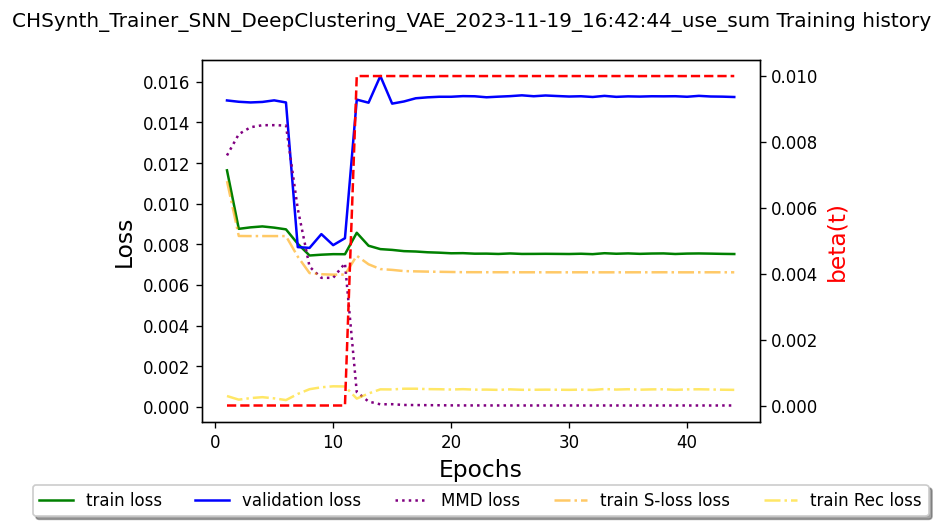

In [16]:
fig, ax = plt.subplots(dpi=120)
#fig.tight_layout(pad=3)
fig.suptitle(f"{model.model_name} Training history")
ax.plot(range(1,len(model.training_loss)+1)  , model.training_loss, color='green', linestyle='-', label='train loss')
ax.plot(range(1,len(model.validation_loss)+1), model.validation_loss, color='blue', linestyle='-', label='validation loss')

if model.beta_t:
    beta_arr = np.array([model.beta_t(epoch) for epoch in range(len(model.training_loss))])
    if beta_arr.max() > 0:
        ax.plot(range(1,len(model.training_loss)+1)  , beta_arr.max()*np.array(model.mmd_losses), color='purple', linestyle=':', label='MMD loss')

try:
    #ax.plot(range(1,len(training_loss)+1), γ*np.array(s_losses), color='orange', linestyle=':', label='train S-loss loss', alpha=0.6)
    # fake for label
    ax.plot(range(1,len(model.training_loss)+1), model.rec_losses, color='orange', linestyle='-.', label='train S-loss loss', alpha=0.6)
    ax.plot(range(1,len(model.training_loss)+1), model.γ * np.array(model.s_losses), color='gold', linestyle='-.', label='train Rec loss', alpha=0.6)
    
except Exception as e:
    print(e)
    pass

ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Loss',fontsize=14)
#ax.set_ylim( np.array(training_loss).min(), np.array(training_loss).max() )
#ax.set_ylim( 0., 0.1125) 
#plt.ylim(ymin = 33, ymax=40.0)


if model.beta_t:
    beta_arr = np.array( [model.beta_t(epoch) for epoch in range(len(model.training_loss))] )
    if beta_arr[0] != beta_arr[-1]:
        # twin object for two different y-axis on the sample plot
        ax2=ax.twinx()
        # make a plot with different y-axis using second axis object
        ax2.plot(range(1,len(model.training_loss)+1), beta_arr, color='red', linestyle='--', label='train loss')
        ax2.set_ylabel("beta(t)", color="red",fontsize=14)

        #ax2.set_ylim(-0.1, beta_arr.max())


elif model.gamma_t:
    beta_arr = [model.gamma_t(epoch) for epoch in range(len(model.training_loss))]
    if beta_arr[0] != beta_arr[-1]:
        # twin object for two different y-axis on the sample plot
        ax2=ax.twinx()
        # make a plot with different y-axis using second axis object
        ax2.plot(range(1,len(model.training_loss)+1), beta_arr, color='red', linestyle='-', label='train loss')
        ax2.set_ylabel("gamma(t)", color="red",fontsize=14)

        ax2.set_ylim(-0.1, 0.5)
else:
    # plot gamma
    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(range(1,len(model.training_loss)+1), model.γ*np.array(model.s_losses), color='orange', linestyle=':', label='train S-loss loss', alpha=0.6)
    ax2.set_ylabel("Cluster Loss", color="orange",fontsize=14)

    #ax2.set_ylim(-0.1, 3.0)

#ax.legend()
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
        
fig.savefig(f"{model.BASE_PATH_TO_STORE}/{model.model_name}.png", bbox_inches='tight')
fig.show()

### Test Model


In [17]:
model.test_model()

Best model ./model_data/SynthCH//CHSynth_Trainer_SNN_DeepClustering_VAE_2023-11-19_16:42:44_use_sum.pth at epoch:  14


  0%|          | 0/205 [00:00<?, ?it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  0%|          | 1/205 [00:00<00:48,  4.19it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  1%|          | 2/205 [00:00<00:46,  4.34it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  1%|▏         | 3/205 [00:00<00:47,  4.24it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  2%|▏         | 4/205 [00:00<00:45,  4.39it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  2%|▏         | 5/205 [00:01<00:44,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  3%|▎         | 6/205 [00:01<00:44,  4.52it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  3%|▎         | 7/205 [00:01<00:43,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  4%|▍         | 8/205 [00:01<00:43,  4.56it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  4%|▍         | 9/205 [00:02<00:42,  4.58it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  5%|▍         | 10/205 [00:02<00:42,  4.58it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  5%|▌         | 11/205 [00:02<00:42,  4.59it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  6%|▌         | 12/205 [00:02<00:42,  4.59it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  6%|▋         | 13/205 [00:02<00:41,  4.60it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  7%|▋         | 14/205 [00:03<00:41,  4.59it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  7%|▋         | 15/205 [00:03<00:41,  4.57it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  8%|▊         | 16/205 [00:03<00:41,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  8%|▊         | 17/205 [00:03<00:45,  4.13it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  9%|▉         | 18/205 [00:04<00:44,  4.24it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


  9%|▉         | 19/205 [00:04<00:42,  4.33it/s]

Error;	K: 4;	uniq: 2
Error;	K: 5;	uniq: 2
Error;	K: 6;	uniq: 2
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 10%|▉         | 20/205 [00:04<00:42,  4.40it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 10%|█         | 21/205 [00:04<00:41,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 11%|█         | 22/205 [00:04<00:40,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 11%|█         | 23/205 [00:05<00:40,  4.51it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 12%|█▏        | 24/205 [00:05<00:40,  4.52it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 12%|█▏        | 25/205 [00:05<00:39,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 13%|█▎        | 26/205 [00:05<00:43,  4.13it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 13%|█▎        | 27/205 [00:06<00:42,  4.24it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 14%|█▎        | 28/205 [00:06<00:41,  4.31it/s]

Error;	K: 4;	uniq: 2
Error;	K: 5;	uniq: 2
Error;	K: 6;	uniq: 2
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 14%|█▍        | 29/205 [00:06<00:40,  4.36it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 15%|█▍        | 30/205 [00:06<00:39,  4.40it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 15%|█▌        | 31/205 [00:07<00:40,  4.27it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 16%|█▌        | 32/205 [00:07<00:39,  4.35it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 16%|█▌        | 33/205 [00:07<00:39,  4.38it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 17%|█▋        | 34/205 [00:07<00:38,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 17%|█▋        | 35/205 [00:07<00:41,  4.08it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 18%|█▊        | 36/205 [00:08<00:39,  4.23it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 18%|█▊        | 37/205 [00:08<00:38,  4.33it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 19%|█▊        | 38/205 [00:08<00:37,  4.40it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 19%|█▉        | 39/205 [00:08<00:37,  4.43it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 20%|█▉        | 40/205 [00:09<00:37,  4.44it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 20%|██        | 41/205 [00:09<00:36,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 20%|██        | 42/205 [00:09<00:36,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 21%|██        | 43/205 [00:09<00:36,  4.49it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 21%|██▏       | 44/205 [00:09<00:35,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 22%|██▏       | 45/205 [00:10<00:35,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 22%|██▏       | 46/205 [00:10<00:35,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 23%|██▎       | 47/205 [00:10<00:35,  4.46it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 23%|██▎       | 48/205 [00:10<00:35,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 24%|██▍       | 49/205 [00:11<00:34,  4.51it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 24%|██▍       | 50/205 [00:11<00:34,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 25%|██▍       | 51/205 [00:11<00:33,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 25%|██▌       | 52/205 [00:11<00:33,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 26%|██▌       | 53/205 [00:11<00:33,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 26%|██▋       | 54/205 [00:12<00:36,  4.19it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 27%|██▋       | 55/205 [00:12<00:34,  4.30it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 27%|██▋       | 56/205 [00:12<00:33,  4.39it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 28%|██▊       | 57/205 [00:12<00:33,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 28%|██▊       | 58/205 [00:13<00:32,  4.50it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 29%|██▉       | 59/205 [00:13<00:32,  4.51it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 29%|██▉       | 60/205 [00:13<00:31,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 30%|██▉       | 61/205 [00:13<00:31,  4.52it/s]

Error;	K: 4;	uniq: 2
Error;	K: 5;	uniq: 2
Error;	K: 6;	uniq: 2
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 30%|███       | 62/205 [00:13<00:31,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 31%|███       | 63/205 [00:14<00:34,  4.16it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 31%|███       | 64/205 [00:14<00:32,  4.28it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 32%|███▏      | 65/205 [00:14<00:31,  4.38it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 32%|███▏      | 66/205 [00:14<00:31,  4.45it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 33%|███▎      | 67/205 [00:15<00:30,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 33%|███▎      | 68/205 [00:15<00:30,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 34%|███▎      | 69/205 [00:15<00:30,  4.51it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 34%|███▍      | 70/205 [00:15<00:29,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 35%|███▍      | 71/205 [00:16<00:29,  4.54it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 35%|███▌      | 72/205 [00:16<00:29,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 36%|███▌      | 73/205 [00:16<00:29,  4.49it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 36%|███▌      | 74/205 [00:16<00:28,  4.52it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 37%|███▋      | 75/205 [00:16<00:28,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 37%|███▋      | 76/205 [00:17<00:28,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 38%|███▊      | 77/205 [00:17<00:28,  4.54it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 38%|███▊      | 78/205 [00:17<00:27,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 39%|███▊      | 79/205 [00:17<00:27,  4.55it/s]

Error;	K: 4;	uniq: 2
Error;	K: 5;	uniq: 2
Error;	K: 6;	uniq: 2
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 39%|███▉      | 80/205 [00:18<00:27,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 40%|███▉      | 81/205 [00:18<00:27,  4.55it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 40%|████      | 82/205 [00:18<00:30,  4.07it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 40%|████      | 83/205 [00:18<00:29,  4.20it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 41%|████      | 84/205 [00:18<00:28,  4.30it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 41%|████▏     | 85/205 [00:19<00:27,  4.39it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 42%|████▏     | 86/205 [00:19<00:26,  4.43it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 42%|████▏     | 87/205 [00:19<00:26,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 43%|████▎     | 88/205 [00:19<00:25,  4.52it/s]

Error;	K: 4;	uniq: 2
Error;	K: 5;	uniq: 2
Error;	K: 6;	uniq: 2
Error;	K: 7;	uniq: 2
Error;	K: 8;	uniq: 2


 43%|████▎     | 89/205 [00:20<00:25,  4.52it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 44%|████▍     | 90/205 [00:20<00:25,  4.54it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 44%|████▍     | 91/205 [00:20<00:27,  4.15it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 45%|████▍     | 92/205 [00:20<00:26,  4.28it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 45%|████▌     | 93/205 [00:21<00:25,  4.38it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 46%|████▌     | 94/205 [00:21<00:24,  4.44it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 46%|████▋     | 95/205 [00:21<00:24,  4.48it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 47%|████▋     | 96/205 [00:21<00:24,  4.52it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 47%|████▋     | 97/205 [00:21<00:23,  4.54it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 48%|████▊     | 98/205 [00:22<00:23,  4.57it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 48%|████▊     | 99/205 [00:22<00:23,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 49%|████▉     | 100/205 [00:22<00:23,  4.53it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 2


 49%|████▉     | 101/205 [00:22<00:23,  4.42it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


 50%|████▉     | 102/205 [00:22<00:23,  4.47it/s]

Error;	K: 4;	uniq: 1
Error;	K: 5;	uniq: 1
Error;	K: 6;	uniq: 1
Error;	K: 7;	uniq: 1
Error;	K: 8;	uniq: 1


100%|██████████| 205/205 [00:59<00:00,  3.42it/s]



		====> Test loss: 0.018951  <====



## Visualize Model

### Reload model if needed

In [6]:
LOAD_MODEL_FROM_DISK = not False # <============ HERE =======
USE_MODEL_KWARGS = False

if LOAD_MODEL_FROM_DISK:
    #LOAD_NAME = 'CHSynth_Trainer_SNN_DeepClustering_AE_2023-11-17_13:25:57_use_sum'
    LOAD_NAME = 'CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_09:27:46_use_sum'
    #USE_SNN  = True
    #BETA_MIN = 1.0
    #BETA_MAX = 1.0
    #GAMMA_INIT = 0.0
    
    BASE_MODEL_NAME  = 'Dummy_'
    if USE_MODEL_KWARGS:
        model_kwargs = {
            "n_layers" : 3,
            "encoding_space_dim" : 32,
            "latent_space_dim" : 3,
            "use_latent_space_activation" : False,
            "min_n_cluster" : 2,
            "max_n_cluster" : 3,
            "use_SNN" : USE_SNN, 
            #
            "random_centroid_init" : True ,
        }

        kwargs = {
            **model_kwargs, 
            "DO_NORMALIZE" : True, 
            # Batch
            "BATCH_SIZE" : 512,
            "PATIENCE" : 25,
            "epochs"   : 100, 
            # Model name
            "BASE_PATH_TO_STORE" : './model_data_synth',
            "base_model_name"    : BASE_MODEL_NAME , 
            #
            "BETA_MIN" : BETA_MIN, 
            "BETA_MAX" : BETA_MAX,
            #
            "γ_init" : GAMMA_INIT,
            "USE_VARYING_GAMMA": False,
            "USE_SUM": True,
            #
            'CUSTOM_TRANSFORM': True,  # smooth
        }

    model = DeepClustering_trainer(**kwargs)
    model.model_name         = LOAD_NAME
    model.BASE_PATH_TO_STORE = f"./model_data/SynthCH/{LOAD_NAME.replace(':', '')}"
    model.full_path_to_store = f'./model_data/SynthCH/{LOAD_NAME}'
    
    model.load_model(load_from_json=not True)
    
    model.β_t     = BETA_MAX
    model.gamma_t = GAMMA_INIT
    model.γ       = GAMMA_INIT
else:
    model.load_model() 

Preparing dataset.
Using custom transform: False

Train set:


100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


Test set:


100%|██████████| 4/4 [00:01<00:00,  2.24it/s]



Done.


 50%|█████     | 1/2 [00:00<00:00,  1.41it/s]

Max Dataset size of 100000 reached.
Returning dataset of shape:	torch.Size([104856, 512])
DeepClustering_VAE1D(
  (final_activation): Sigmoid()
  (IKMeans): DC_IterativeKMeans()
  (encoder): VAEencoder(
    (encoder): Sequential(
      (0): SNN(
        (network): Sequential(
          (fc0): Linear(in_features=512, out_features=256, bias=False)
          (selu_0): SELU()
          (dropout_0): AlphaDropout(p=0.1, inplace=False)
          (fc1): Linear(in_features=256, out_features=128, bias=False)
          (selu_1): SELU()
          (dropout_1): AlphaDropout(p=0.1, inplace=False)
          (fc2): Linear(in_features=128, out_features=64, bias=False)
          (selu_2): SELU()
          (dropout_2): AlphaDropout(p=0.1, inplace=False)
          (fc_3): Linear(in_features=64, out_features=32, bias=True)
        )
      )
      (1): Tanh()
    )
    (fc_mu): Linear(in_features=32, out_features=3, bias=True)
    (fc_var): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): V

### Load XRF

In [7]:
from utils.open_model import load_model_func

In [8]:
#path_to_file = '/jupyter/notebooks/Article/CHData/Synth/2D/val/1652.h5'
#path_to_file = '/jupyter/notebooks/Article/CHData/Synth/2D/val/1811_new.h5'
#path_to_file = '/jupyter/notebooks/Article/CHData/Synth/2D/val/1764_new.h5'

#path_to_file = '/jupyter/notebooks/Article/CHData/Synth/2D/val/1648.h5'
path_to_file = '/jupyter/notebooks/Article/CHData/Synth/2D/val/1648_06.h5' 

name_of_xrf = path_to_file.split('/')[-1].split('.')[0]

print(f"Opening {name_of_xrf}")
with h5py.File(path_to_file, 'r') as _h5:
    # Open
    ma_xrf = torch.Tensor( np.array(_h5['img'][()], dtype=float) ).float()
    _shape = ma_xrf.shape
    # Rebin 
    ma_xrf = ma_xrf.to(device)
    ma_xrf = rebin_xrf( ma_xrf.reshape(-1, _shape[-1]), n_bins=512 )
    ma_xrf = ma_xrf.reshape(*_shape[:2], _shape[-1])
    # Transform
    ma_xrf = model.custom_transform_realized(ma_xrf)

Opening 1648_06


### Perform Clustering

Best model ./model_data/SynthCH/CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_092746_use_sum/CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_09:27:46_use_sum.pth at epoch:  32
CUDA out of memory. Tried to allocate 23.37 GiB (GPU 0; 14.76 GiB total capacity; 1.43 GiB already allocated; 11.90 GiB free; 1.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 23.30 GiB (GPU 0; 14.76 GiB total capacity; 1.43 GiB already allocated; 11.90 GiB free; 1.76 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 23.18 GiB (GPU 0; 14.76 GiB total capacity; 1.43 GiB already allocated; 11.90 GiB free; 1.76 GiB reserved in total by Py

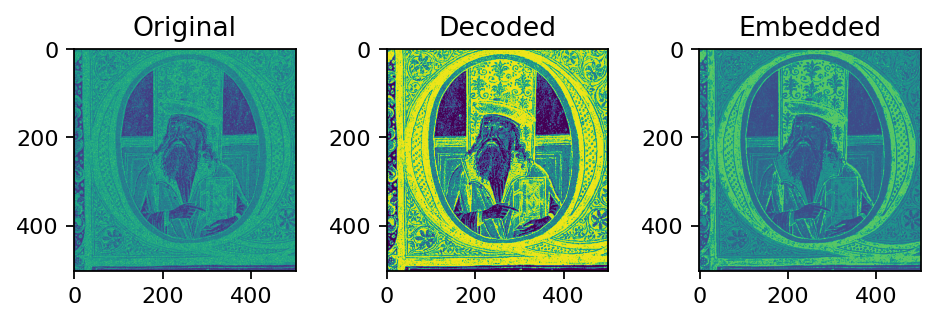

In [9]:
# Load best model
model.load_model()

_final_shape = ma_xrf.shape
transformed_ma_xrf, _, mu, _, best_cl, best_c, best_score, best_K, s_scores  = model( ma_xrf.reshape(-1, _final_shape[-1] ) )

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=160)
fig.tight_layout(pad=1)
ax[0].imshow(ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy() )
ax[0].set_title('Original')
ax[1].imshow(transformed_ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy()  )
ax[1].set_title('Decoded')
ax[2].imshow( mu.reshape([*_final_shape[:2], mu.shape[-1]] ).sum(dim=-1).detach().cpu().numpy()  )
ax[2].set_title('Embedded')

plt.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_integrated_xrf_{name_of_xrf}.png')

plt.show()

In [10]:
DO_THIS = False

if DO_THIS:

    from utils.custom_dataset import MAXRFVizDataset

    ma_xrf_dataset = MAXRFVizDataset(
        path_to_datacube = path_to_file,
        data_name = 'img',
        transform = model.custom_transform_realized,
        MAX_BIN = 512, 
        REBIN_SIZE = 512,
    )

    ma_xrf_dataloader =  DataLoader(
        ma_xrf_dataset,  
        batch_size=model.BATCH_SIZE, 
        shuffle=False
    )

    # Load best model
    model.load_model()

    ma_xrf = torch.zeros(ma_xrf_dataset.final_shape)
    transformed_ma_xrf  = torch.zeros_like(ma_xrf)

    mu = torch.zeros([ma_xrf_dataset.__len__(), model.latent_space_dim])
    best_cl = torch.zeros(ma_xrf_dataset.__len__())
    best_c  = []
    best_score = 0.0
    best_K = 0.0 
    s_scores = []

    # Datacube shape
    _final_shape = [*ma_xrf_dataset.shape[:2], ma_xrf_dataset.REBIN_SIZE]

    counter = 0
    for x in tqdm.tqdm(ma_xrf_dataloader):
        x = x.nan_to_num(nan=0.0)
        # Create Original Datacube
        ma_xrf[counter*ma_xrf_dataloader.batch_size:(counter+1)*ma_xrf_dataloader.batch_size, :] = x
        # === Forward ======
        x = x.to(model.device)
        # Forward
        _transformed_ma_xrf, _, _mu, _, _best_cl, _best_c, _best_score, _best_K, _s_scores = model.model(x)
        # Detach
        _transformed_ma_xrf = _transformed_ma_xrf.detach().cpu()
        transformed_ma_xrf[counter*ma_xrf_dataloader.batch_size:(counter+1)*ma_xrf_dataloader.batch_size, :] = _transformed_ma_xrf

        _mu = _mu.detach().cpu()
        mu[counter*ma_xrf_dataloader.batch_size:(counter+1)*ma_xrf_dataloader.batch_size, :] = _mu

        _best_cl = _best_cl.detach().cpu()
        best_cl[counter*ma_xrf_dataloader.batch_size:(counter+1)*ma_xrf_dataloader.batch_size] = _best_cl

        _best_c  = _best_c.detach().cpu()
        best_c.append( _best_c  )

        _best_score = _best_score
        best_score += best_score

        _best_K   = _best_K
        best_K += _best_K 

        _s_scores = _s_scores
        s_scores.append( _s_scores )

        counter += 1
        
        _final_shape = (512, 512, 512)
        #transformed_ma_xrf, _, mu, _, best_cl, best_c, best_score, best_K, s_scores  = model( ma_xrf.reshape(-1, _final_shape[-1] ) )

        fig, ax = plt.subplots(nrows=1, ncols=3, dpi=160)
        fig.tight_layout(pad=1)
        ax[0].imshow(ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy() )
        ax[0].set_title('Original')
        ax[1].imshow(transformed_ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy()  )
        ax[1].set_title('Decoded')
        ax[2].imshow( mu.reshape([*_final_shape[:2], mu.shape[-1]] ).sum(dim=-1).detach().cpu().numpy()  )
        ax[2].set_title('Embedded')

        #plt.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_integrated_xrf.png')

        plt.show()


In [12]:
# pool tensor

with h5py.File(path_to_file, 'r') as _h5:
    # Open
    ma_xrf = torch.Tensor( np.array(_h5['img'][()], dtype=float) ).float()
    _shape = ma_xrf.shape
    # Rebin 
    ma_xrf = ma_xrf.to(device)
    ma_xrf = rebin_xrf( ma_xrf.reshape(-1, _shape[-1]), n_bins=512 )
    ma_xrf = ma_xrf.reshape(*_shape[:2], _shape[-1])
    # Transform
    ma_xrf = model.custom_transform_realized(ma_xrf)
    # Pooling
    m = nn.AvgPool2d(2, stride=2, padding=0)
    ma_xrf =  m(ma_xrf.moveaxis(-1, 0).unsqueeze(0)).squeeze(0).moveaxis(0,-1)
    

CUDA out of memory. Tried to allocate 1.09 GiB (GPU 0; 14.76 GiB total capacity; 12.82 GiB already allocated; 631.00 MiB free; 13.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 542.00 MiB (GPU 0; 14.76 GiB total capacity; 11.25 GiB already allocated; 91.00 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CUDA out of memory. Tried to allocate 200.00 MiB (GPU 0; 14.76 GiB total capacity; 12.83 GiB already allocated; 91.00 MiB free; 13.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
CU

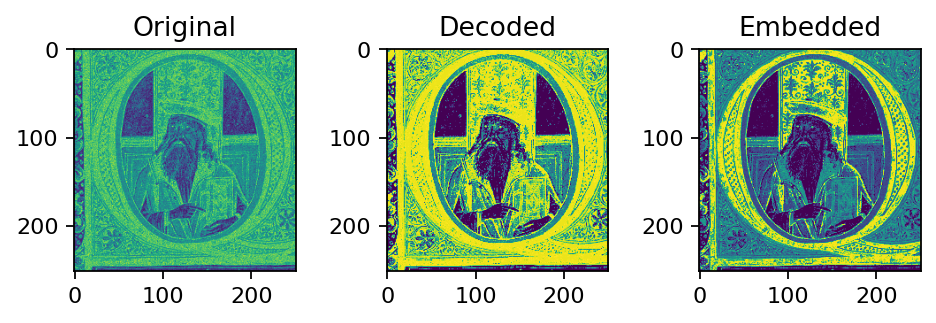

In [13]:
_final_shape = ma_xrf.shape
transformed_ma_xrf, _, mu, _, best_cl, best_c, best_score, best_K, s_scores  = model( ma_xrf.reshape(-1, _final_shape[-1] ) )

fig, ax = plt.subplots(nrows=1, ncols=3, dpi=160)
fig.tight_layout(pad=1)
ax[0].imshow(ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy() )
ax[0].set_title('Original')
ax[1].imshow(transformed_ma_xrf.reshape(*_final_shape).sum(dim=-1).detach().cpu().numpy()  )
ax[1].set_title('Decoded')
ax[2].imshow( mu.reshape([*_final_shape[:2], mu.shape[-1]] ).sum(dim=-1).detach().cpu().numpy()  )
ax[2].set_title('Embedded')

plt.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_integrated_xrf_{name_of_xrf}.png')

plt.show()

In [14]:
# reperform clustering
best_cl, best_c, best_score, best_K, s_scores = IterativeKMeans(
    mu.cpu(), 
    min_n_cluster = 3, max_n_cluster = 10, Niter = 15, random_centroid_init = model.random_centroid_init
)

In [87]:
try:
    from utils.explore_latent_space import plot_clustered
except: 
    %pip install plotly
    from utils.explore_latent_space import plot_clustered

/jupyter/notebooks/Article/utils/explore_latent_space.py:127: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:127: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:127: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:127: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

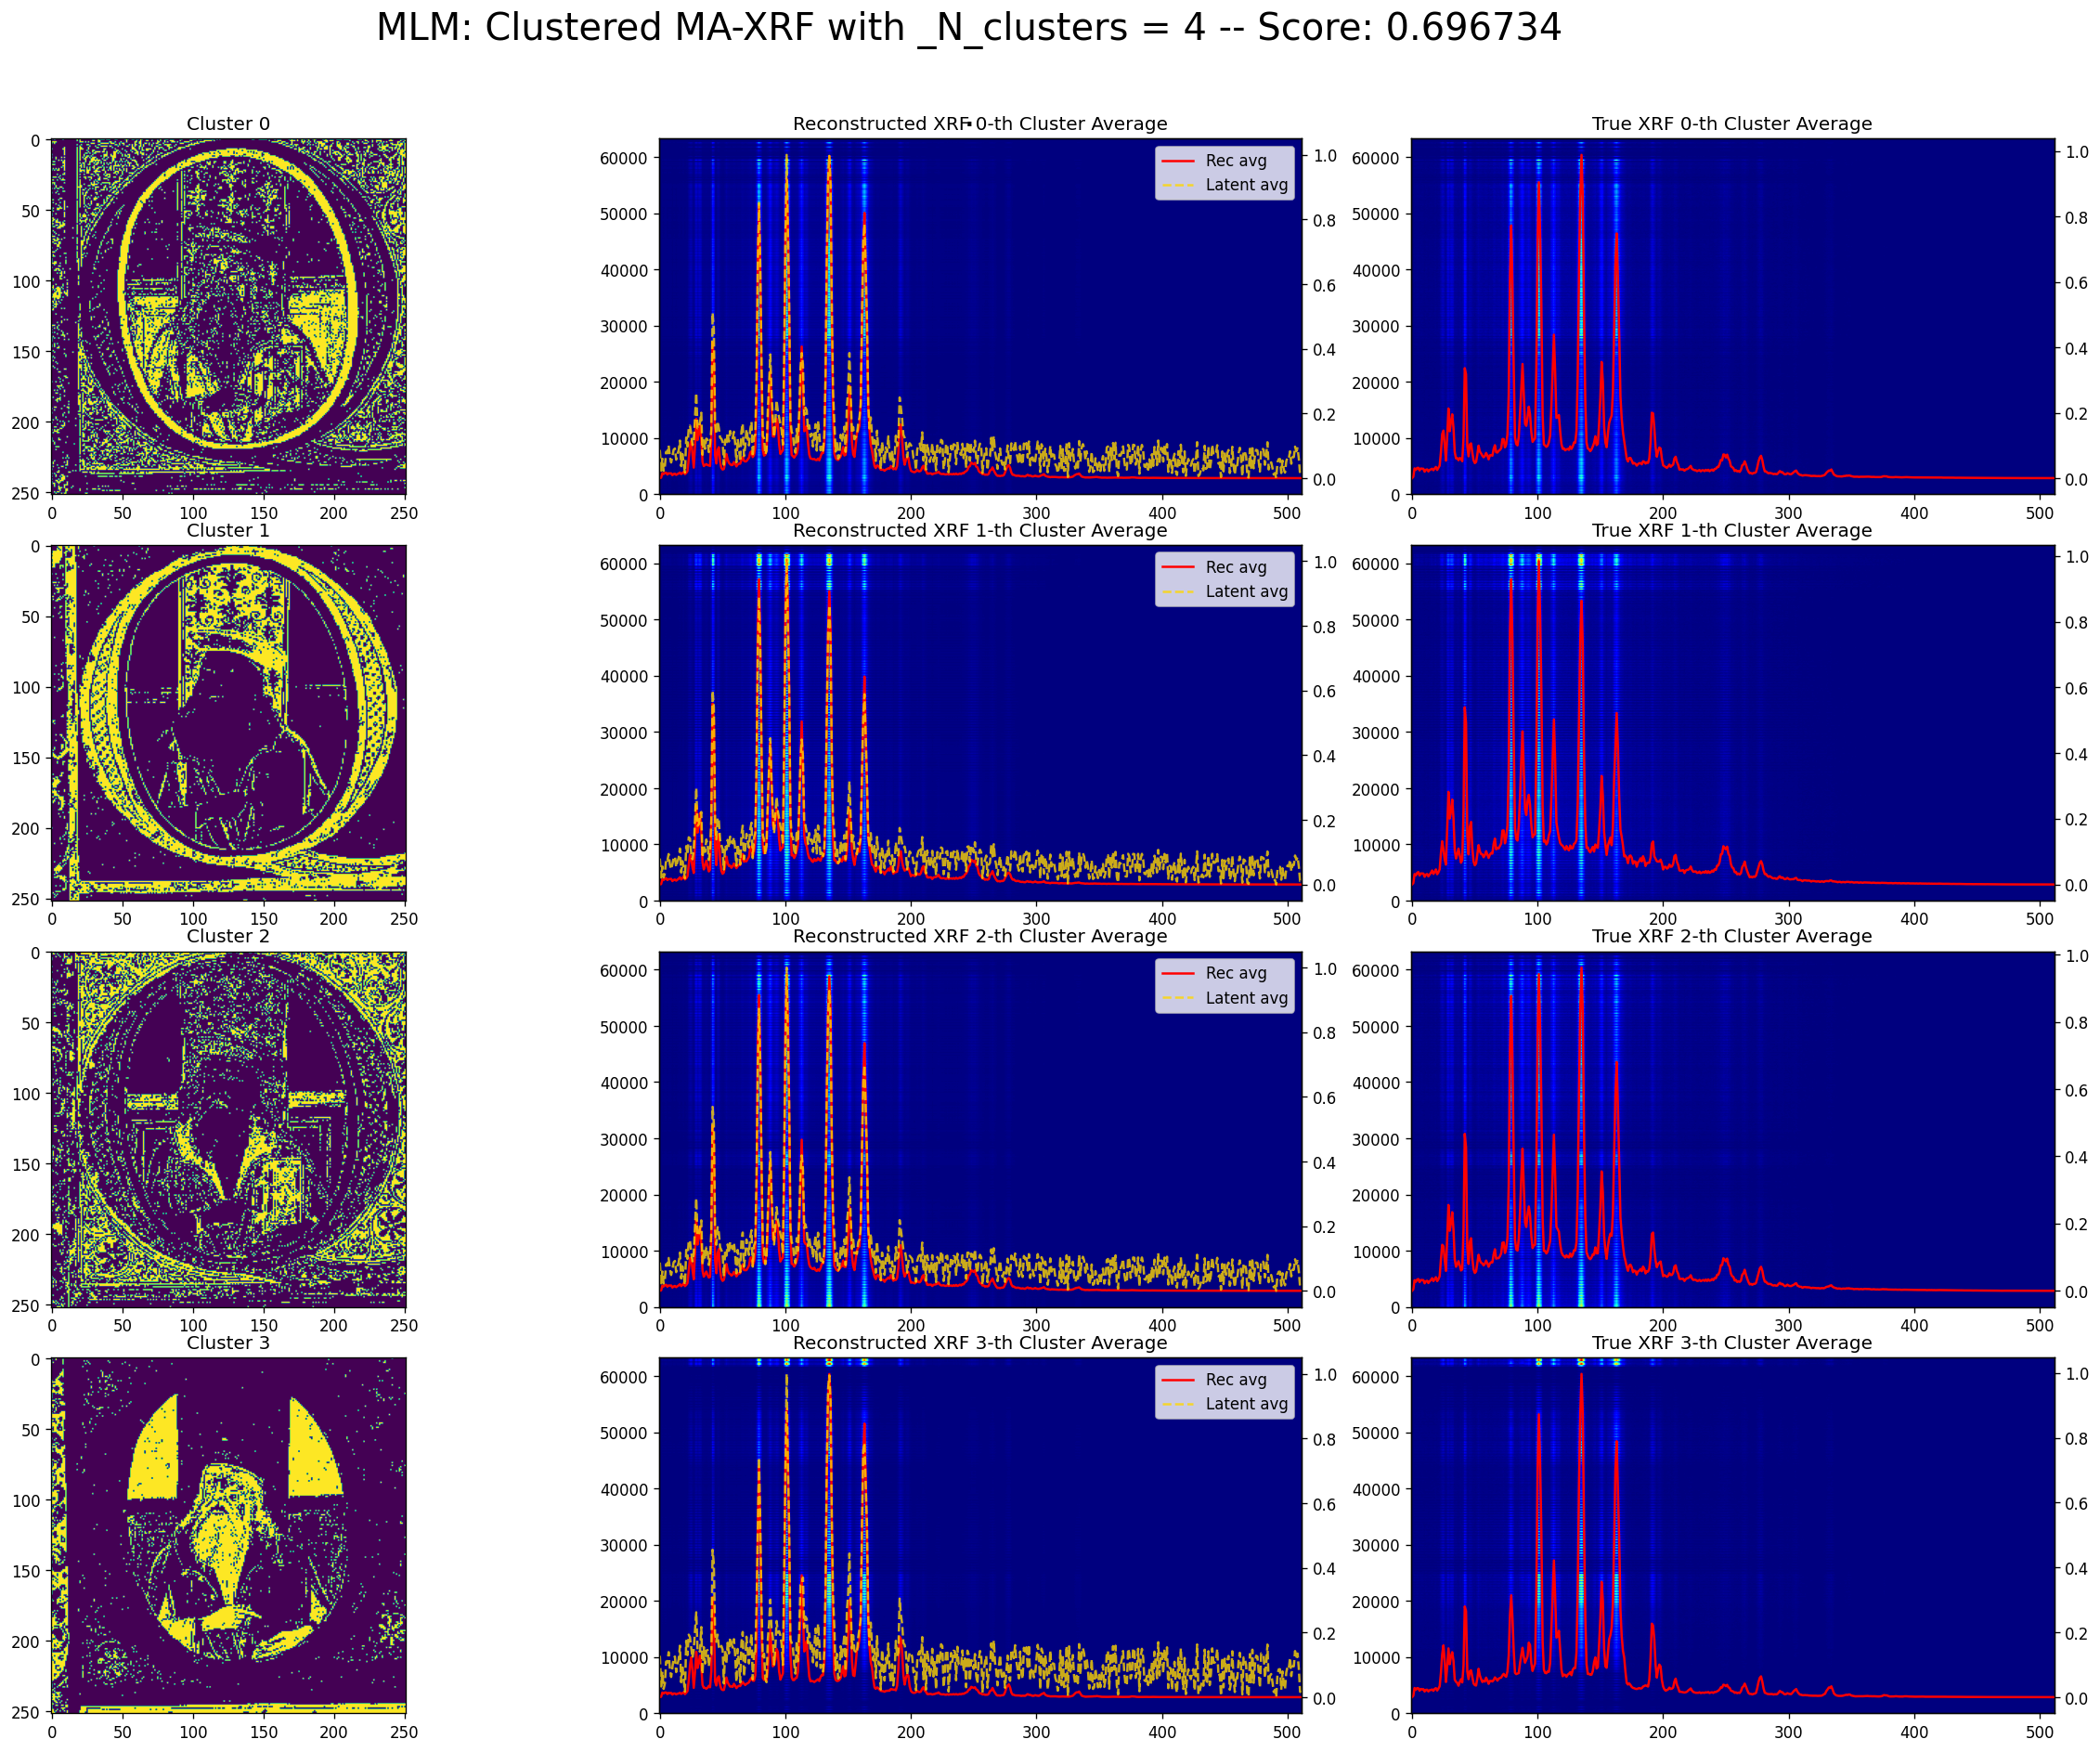

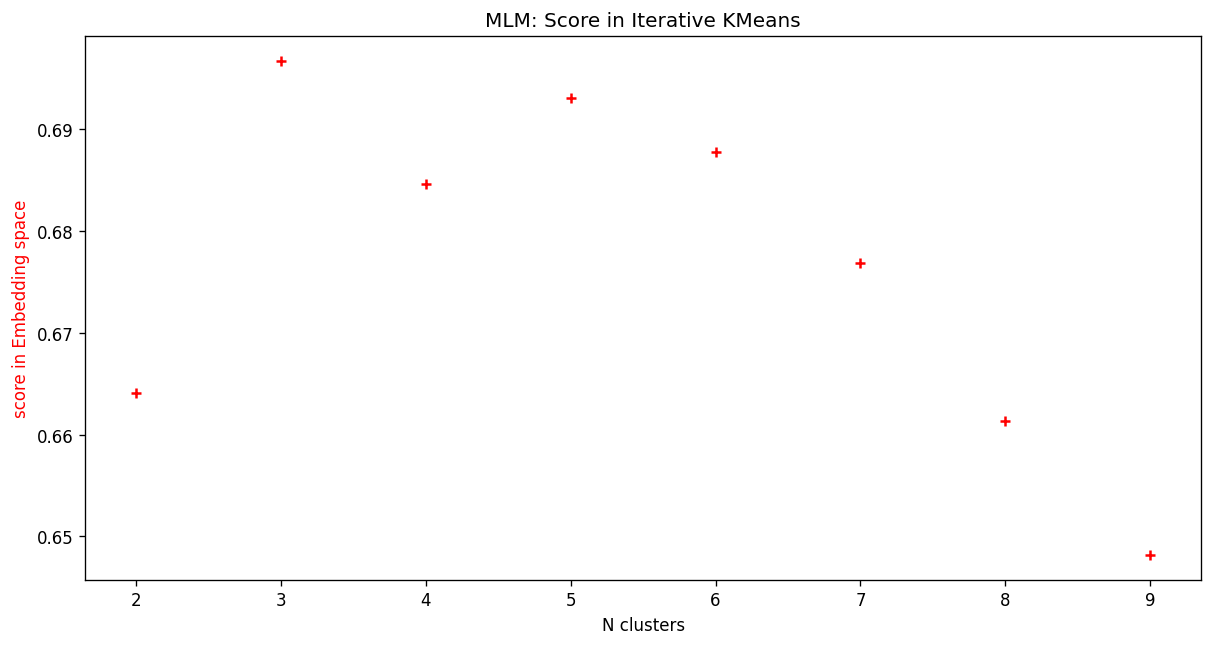

In [88]:
fig_1, fig_2, = plot_clustered(
    ma_xrf.cpu(), transformed_ma_xrf.cpu(), mu.cpu(),
    best_cl.cpu(), best_c.cpu(), best_score, best_K, s_scores.cpu(),
    #torch.tensor(best_cl.clone().detach(), dtype=int) , torch.cat(best_c) , best_score, int(best_cl.max().item()), torch.cat(s_scores),
    _final_shape,
    MIN_CLUSTER = 2, MAX_CLUSTER = 5,
    # add
    tech_name = 'MLM' ,
    decoder = model.model.decoder.cpu()
)

In [89]:
fig_1.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_clustered_xrf_{name_of_xrf}.pdf', bbox_inches="tight")
fig_2.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_iterative_clustering_silhouette_scores_{name_of_xrf}.pdf', bbox_inches="tight")

In [72]:
from utils.explore_latent_space import plot_histograms

/jupyter/notebooks/Article/utils/explore_latent_space.py:299: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:299: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:299: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/jupyter/notebooks/Article/utils/explore_latent_space.py:299: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), r

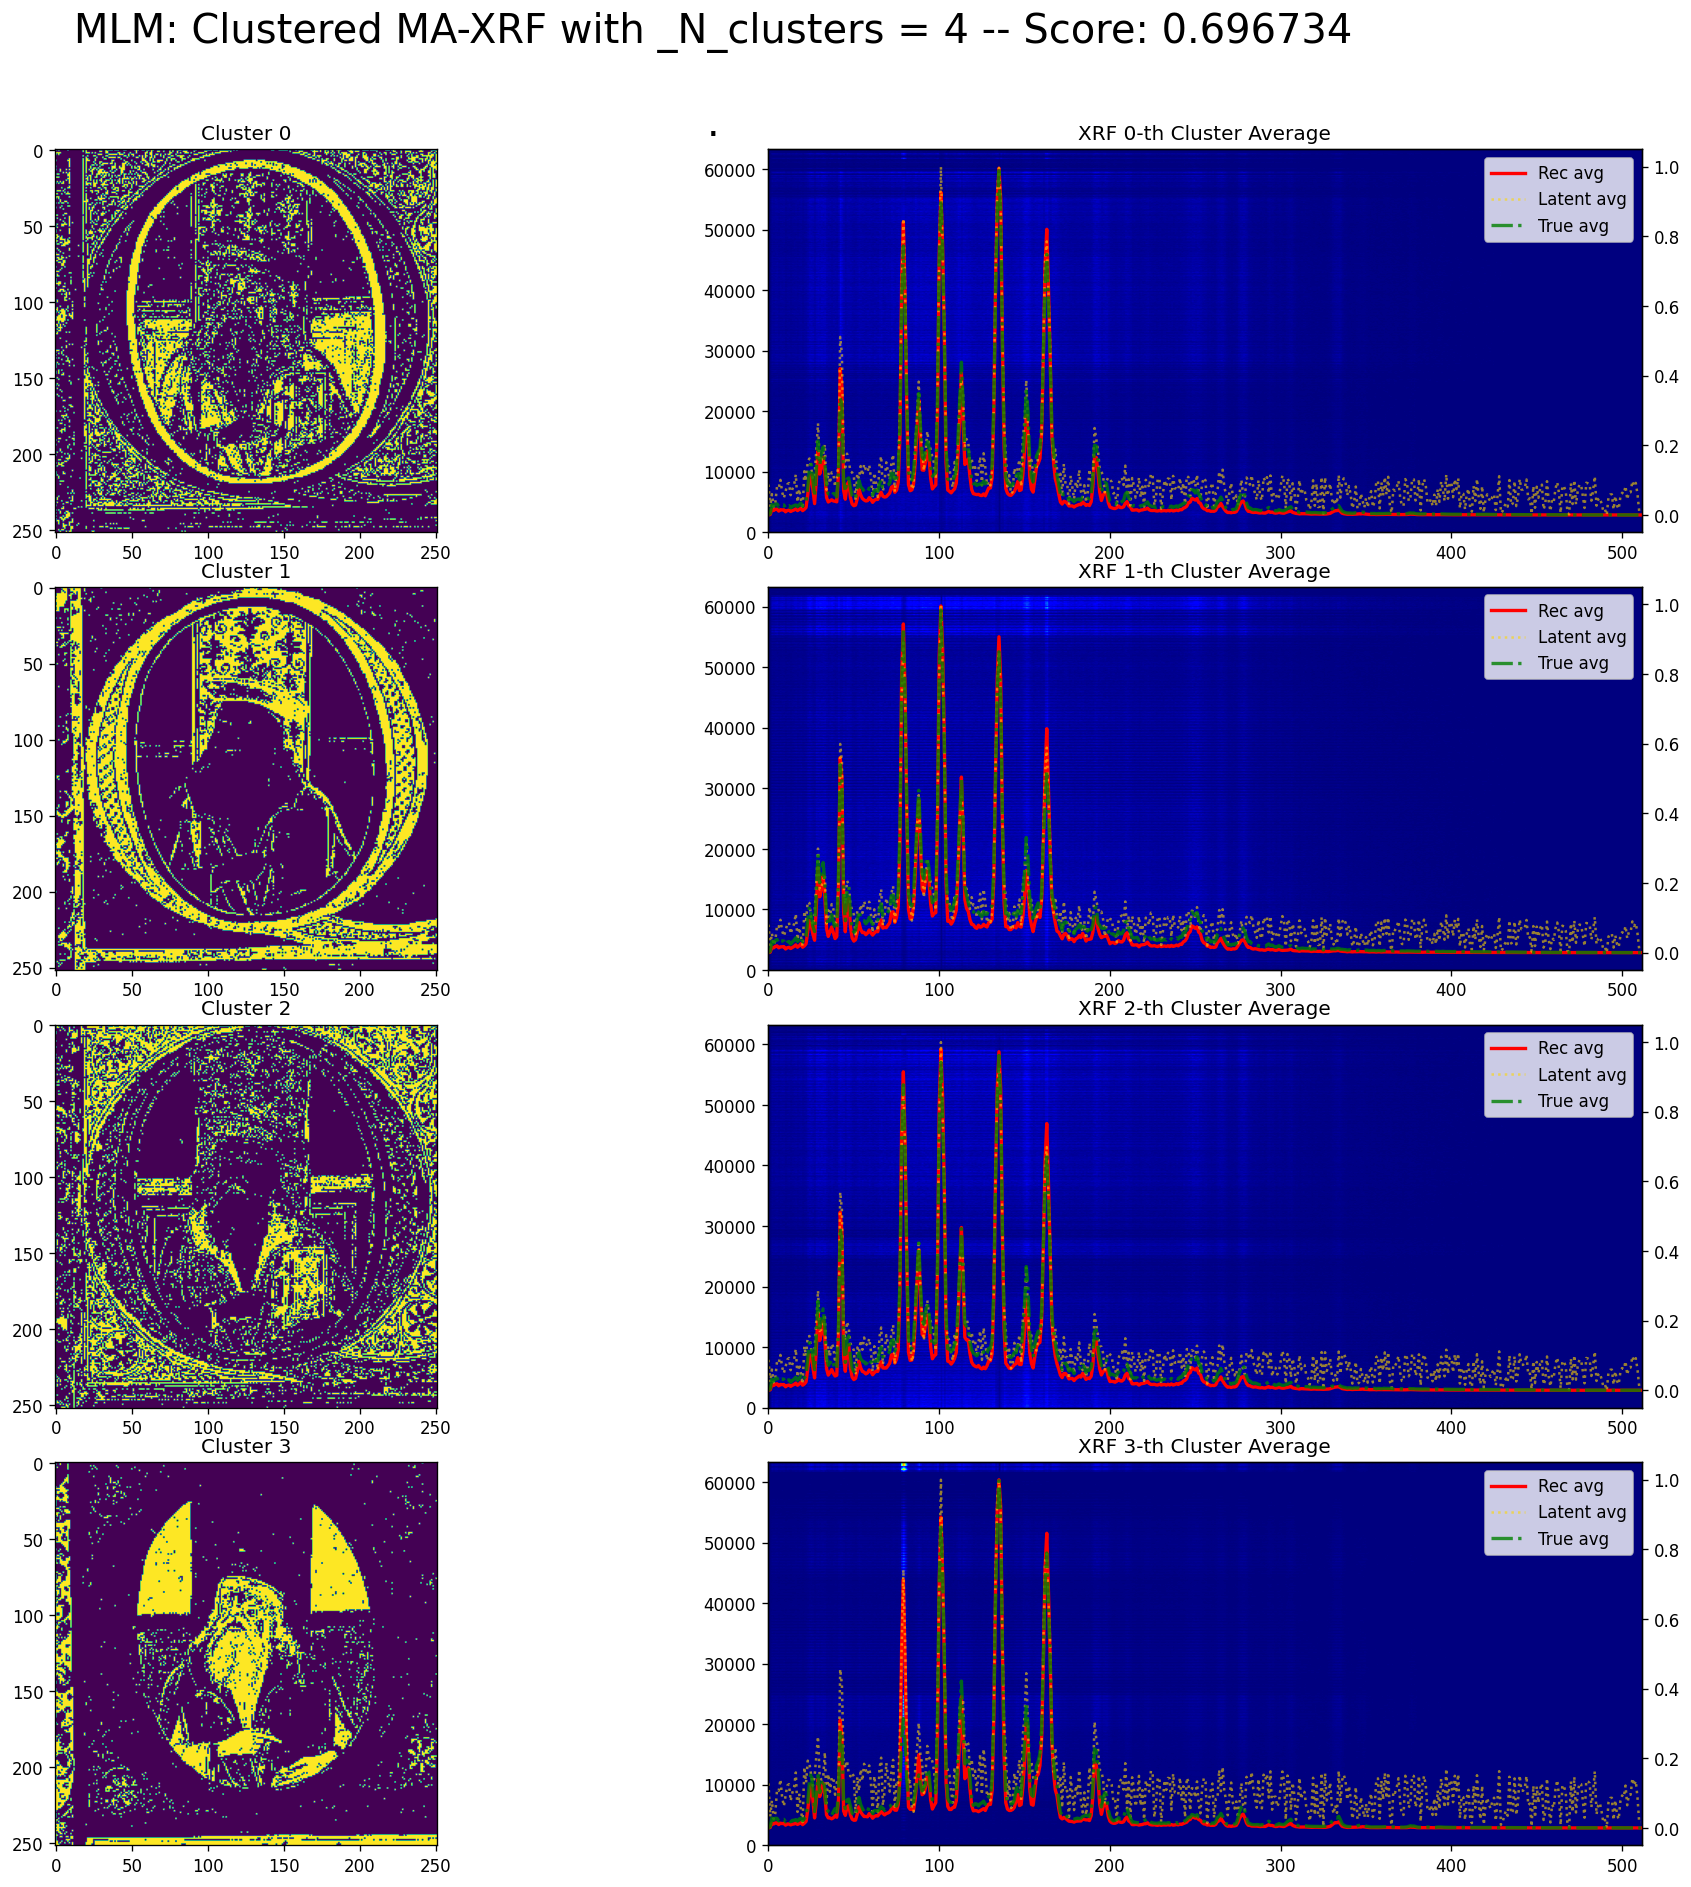

In [84]:
from utils.explore_latent_space import plot_histograms

fig_hist = plot_histograms(
    ma_xrf.cpu(), transformed_ma_xrf.cpu(), mu.cpu(),
    best_cl.cpu(), best_c.cpu(), best_score, best_K, s_scores.cpu(),
    #torch.tensor(best_cl.clone().detach(), dtype=int) , torch.cat(best_c) , best_score, int(best_cl.max().item()), torch.cat(s_scores),
    _final_shape,
    MIN_CLUSTER = 2, MAX_CLUSTER = 5,
    # add
    tech_name = 'MLM' ,
    decoder = model.model.decoder.cpu() ,
    plot_cmap = True
)

In [86]:
fig_hist.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_clustered_histograms_{name_of_xrf}.pdf', bbox_inches="tight")

### Visualize latent Space

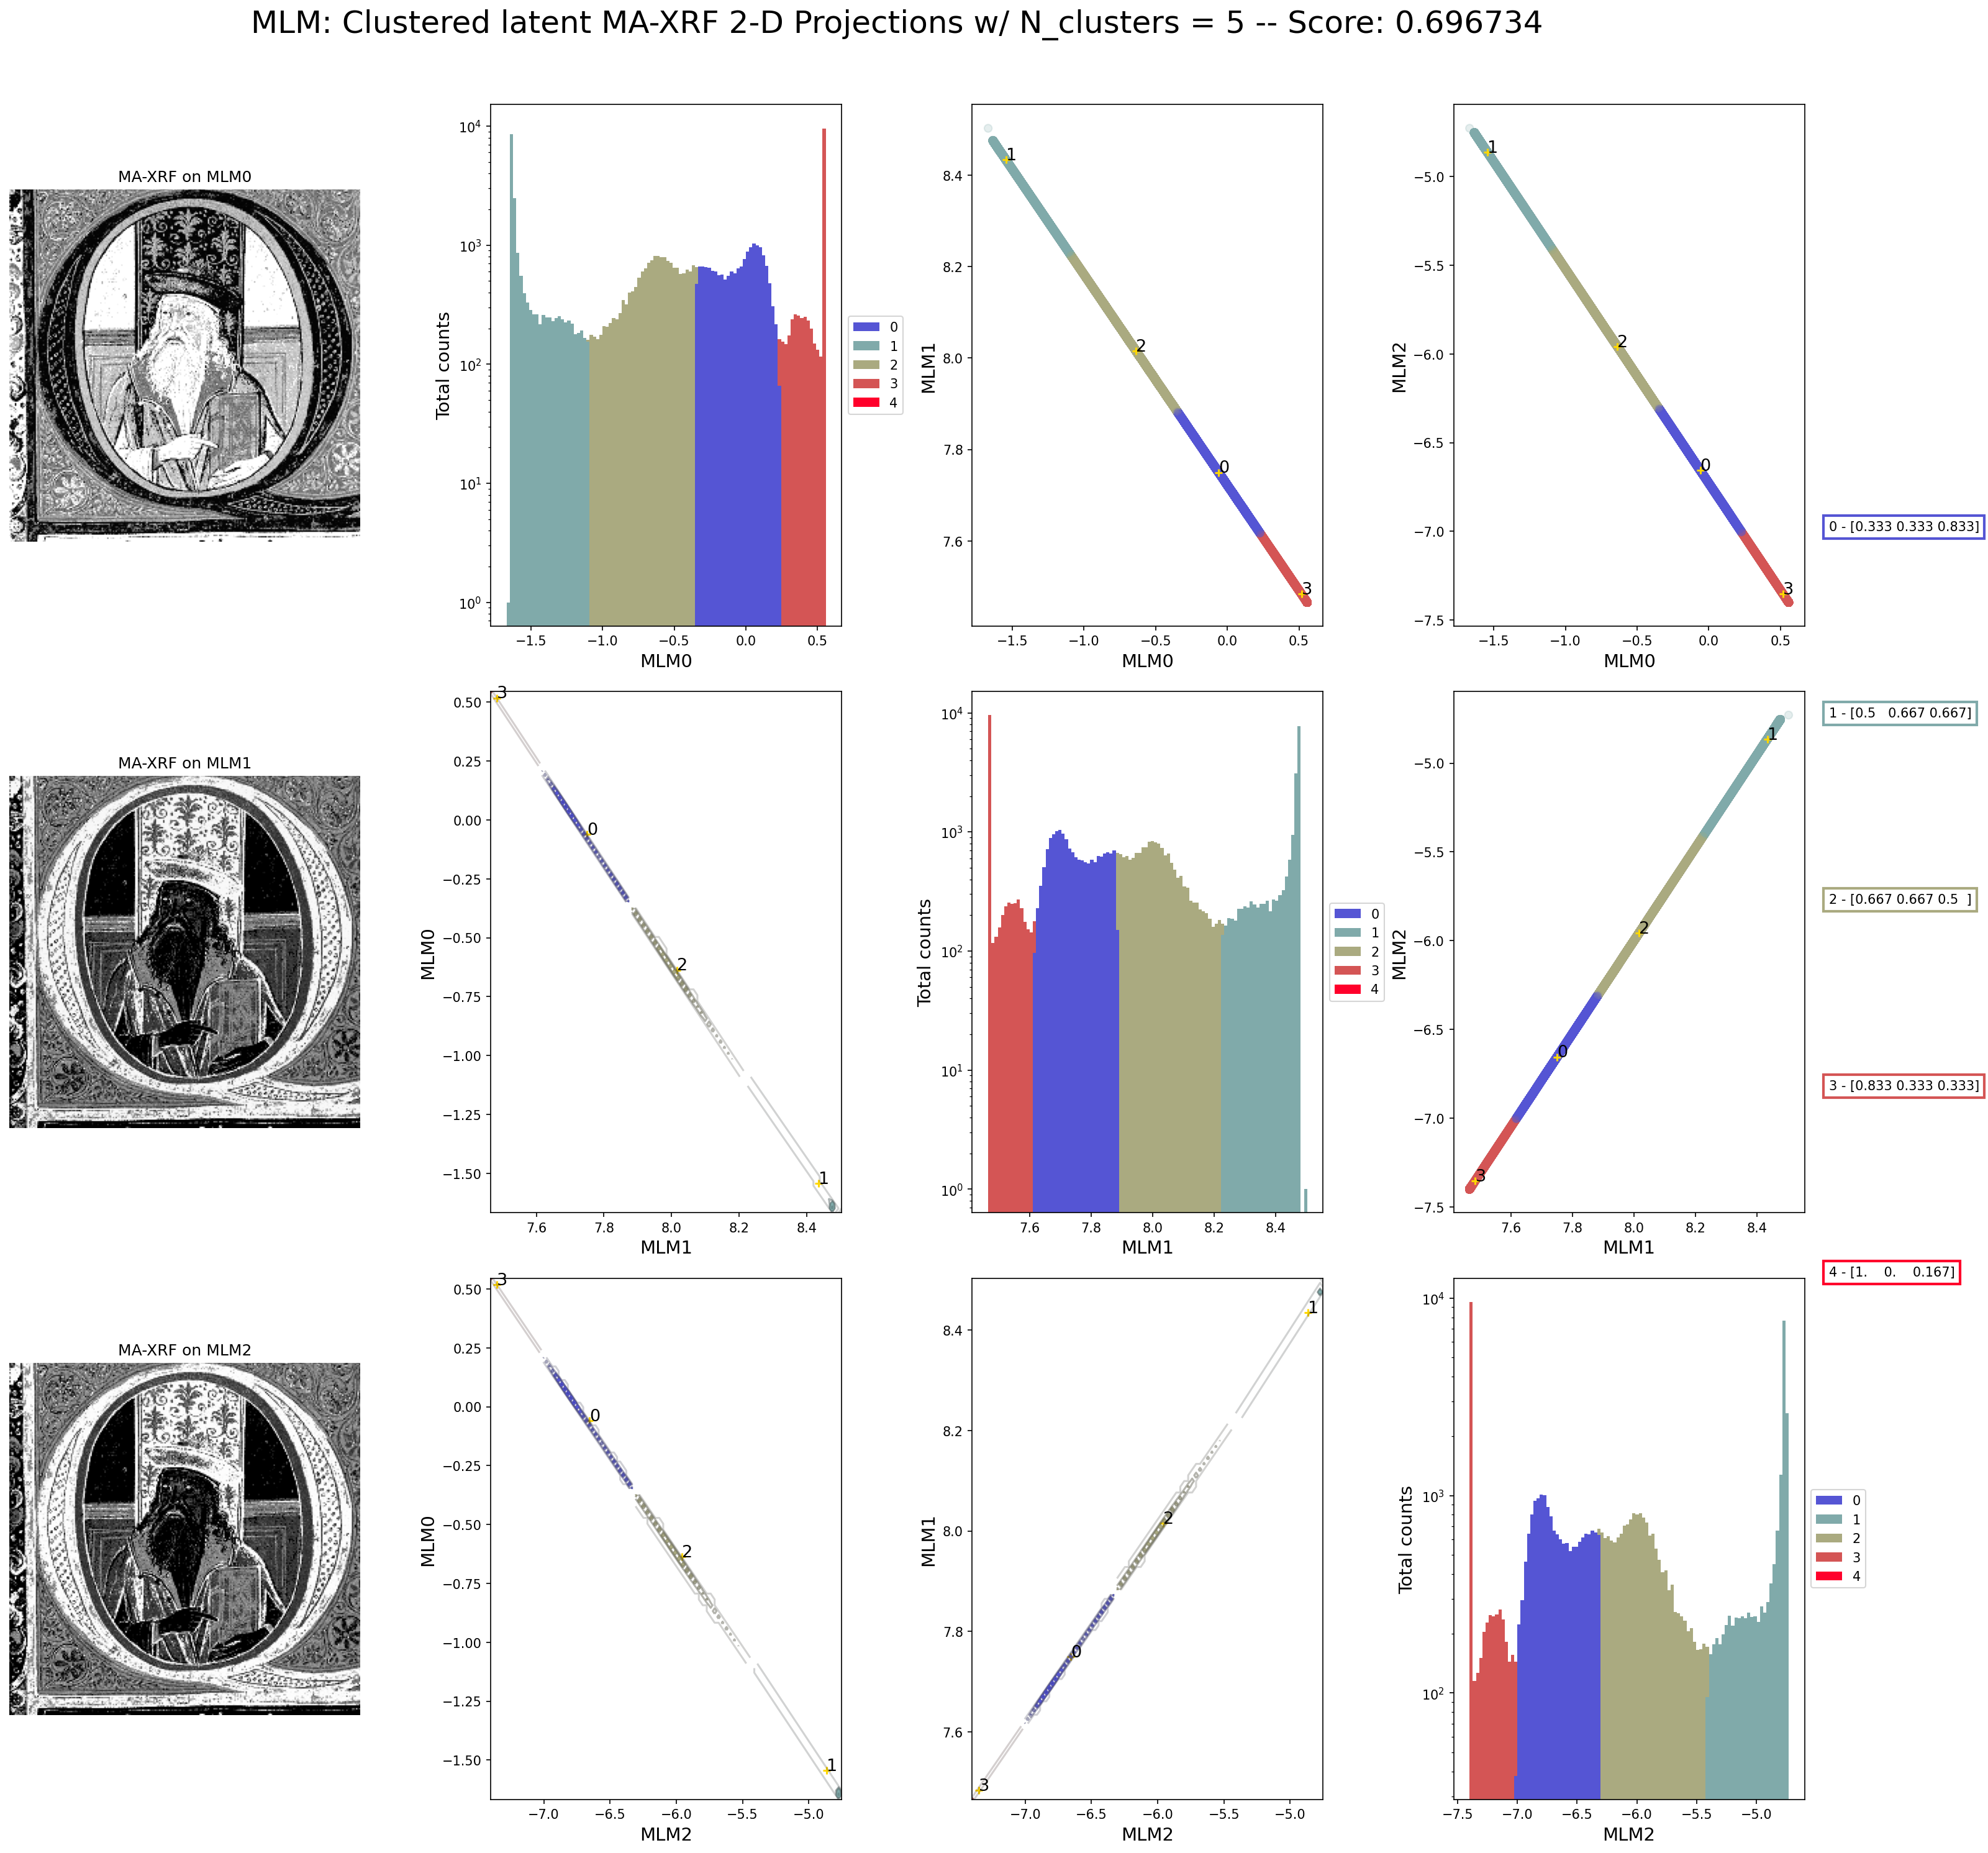

In [17]:
from utils.explore_latent_space import plot_latent_space
fig_3 = plot_latent_space(
    ma_xrf.cpu().detach(), ma_xrf.cpu().detach(), mu.cpu().detach(),
    best_cl.cpu().detach(), best_c.cpu().detach(), best_score, best_K, s_scores.cpu().detach(),
    _final_shape,
    MIN_CLUSTER = 2, MAX_CLUSTER = 5,
    # add
    tech_name = 'MLM',
    N_CONTOUR_LEVELS = 5,
    PLOT_LATENT_SPACE_MA_XRF = True,
    PLOT_HIST_LOG_Y_SCALE = True,
)

In [18]:
fig_3.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_clustered_latent_space_with_XRF_{name_of_xrf}.pdf')

### Explore latent space

In [ ]:
from utils.explore_trained_model import plot_model

untrained_model = DeepClustering_VAE1D(**model.model_kwargs)

In [ ]:
fig, ax = plot_model(
    model_to_plot   = model.model.encoder ,
    untrained_model = untrained_model.encoder , 
    # 
    _suptitle = f"Encoder weights",
    MAGNIFYING_PERCENTAGE = 120, 
)

try:
    fig.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_Encoder_view.pdf')
except Exception as e:
    print(e)
    pass

plt.show()

In [ ]:
fig, ax = plot_model(
    model_to_plot   = model.model.decoder ,
    untrained_model = untrained_model.decoder , 
    # 
    _suptitle = f"Decoder weights",
    MAGNIFYING_PERCENTAGE = 120, 
)

try:
    fig.savefig(f'./{model.BASE_PATH_TO_STORE}/{model.model_name}_Decoder_view.pdf')
except Exception as e:
    print(e)
    pass

plt.show()

In [14]:
import pandas as pd

df = pd.read_csv('./model_data/SynthCH/CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_092746_use_sum/CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_09:27:46_use_sum_history.csv')

In [5]:
df

Unnamed: 0  epochs  training_loss  validation_loss  beta  gamma  \
0            0       0       0.012223         0.020131  0.00   0.01   
1            1       1       0.010693         0.020112  0.00   0.01   
2            2       2       0.011672         0.020020  0.00   0.01   
3            3       3       0.011942         0.020065  0.00   0.01   
4            4       4       0.012315         0.019961  0.00   0.01   
..         ...     ...            ...              ...   ...    ...   
61          61      61       0.014726         0.021638  0.01   0.01   
62          62      62       0.014753         0.021650  0.01   0.01   
63          63      63       0.014738         0.021646  0.01   0.01   
64          64      64       0.014734         0.021637  0.01   0.01   
65          65      65       0.014727         0.021653  0.01   0.01   

              lr  mmd_train_losses  rec_train_losses  clust_losses  
0   1.000000e-03          1.193245          0.011124      0.109971  
1   1.000000e-03          1.303078          0.008412      0.228155  
2   1.000000e-03          1.331536          0.008406      0.326571  
3   1.000000e-03          1.341318          0.008405      0.353630  
4   1.000000e-03          1.340543          0.008406      0.390895  
..           ...               ...               ...           ...  
61  1.000000e-08          0.582201          0.006956      0.194782  
62  1.000000e-08          0.583120          0.006969      0.195229  
63  1.000000e-08          0.582374          0.006973      0.194080  
64  1.000000e-08          0.582835          0.006960      0.194574  
65  1.000000e-08          0.582229          0.006963      0.194154  

[66 rows x 10 columns]

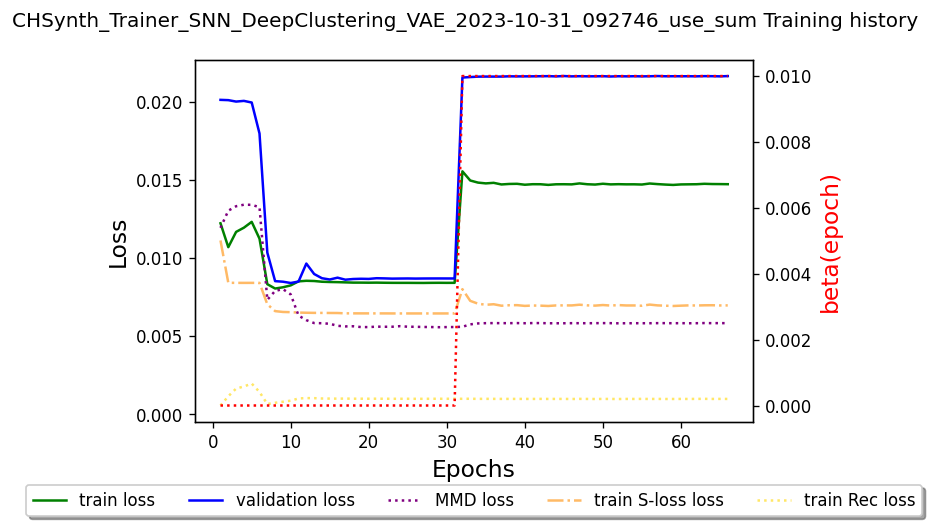

In [26]:
fig, ax = plt.subplots(dpi=120)
#fig.tight_layout(pad=3)
fig.suptitle(f"CHSynth_Trainer_SNN_DeepClustering_VAE_2023-10-31_092746_use_sum Training history")
ax.plot(range(1,len(df['training_loss'])+1)  , df.training_loss, color='green', linestyle='-', label='train loss')
ax.plot(range(1,len(df.validation_loss)+1), df.validation_loss, color='blue', linestyle='-', label='validation loss')
ax.plot(range(1,len(df.training_loss)+1)  , model.β_t * np.array(df.mmd_train_losses), color='purple', linestyle=':', label='MMD loss')
ax2=ax.twinx()

if True:
    beta_arr = df.beta
    if beta_arr.max() > 0:
        ax2.plot(range(1,len(df.training_loss)+1)  , beta_arr, color='red', linestyle=':', label='beta')
        ax2.set_ylabel('beta(epoch)',fontsize=14, c='r')

try:
    #ax.plot(range(1,len(training_loss)+1), γ*np.array(s_losses), color='orange', linestyle=':', label='train S-loss loss', alpha=0.6)
    # fake for label
    ax.plot(range(1,len(df.training_loss)+1), df.rec_train_losses, color='darkorange', linestyle='-.', label='train S-loss loss', alpha=0.6)
    ax.plot(range(1,len(df.training_loss)+1), model.γ*np.array(df.clust_losses), color='gold', linestyle=':', label='train Rec loss', alpha=0.6)
    
except Exception as e:
    print(e)
    pass

ax.set_xlabel('Epochs',fontsize=14)
ax.set_ylabel('Loss',fontsize=14)

#ax.legend()
# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
        
fig.savefig(f"{model.BASE_PATH_TO_STORE}/{model.model_name}_history_2.png", bbox_inches='tight')
fig.show()